In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import kv, factorial, jacobi


# define basis

In [2]:
import numpy as np
from functools import lru_cache
from numpy.polynomial import Polynomial, Legendre


# ============================================================
# Shifted-polynomial coefficients in x for:
#   P_{n-1}^{(alpha,beta)}(1 - 2x) = sum_{j=0}^{n-1} d_{n,j} x^j
# Special cases:
#   b=1      -> alpha=0, beta=0 (Legendre)
#   b=3/2    -> alpha=1, beta=0 (Jacobi)
# General (your basis construction): alpha = 2b - 2, beta = 0
# ============================================================

def _is_half_integer(b: float, tol: float = 1e-12) -> bool:
    """True if b is an integer or half-integer within tolerance."""
    two_b = 2.0 * float(b)
    return abs(two_b - round(two_b)) < tol

def _b_key(b: float, tol: float = 1e-12) -> float:
    """
    Stable cache key for half-integers/integers:
      b = m/2  -> store as exact float m/2 (with m integer)
    """
    if not _is_half_integer(b, tol=tol):
        raise ValueError("This implementation supports integer/half-integer b (e.g., 1, 3/2, 2, 5/2, ...).")
    m = int(round(2.0 * float(b)))
    return m / 2.0

@lru_cache(maxsize=None)
def _d_coeffs_shifted_jacobi(n: int, b_key: float) -> np.ndarray:
    """
    Return d_{n,0..n-1} such that
      P_{n-1}^{(alpha,0)}(1-2x) = sum_j d_{n,j} x^j
    with alpha = 2b - 2, b = b_key (integer/half-integer).
    """
    if int(n) != n or n < 1:
        raise ValueError("n must be an integer >= 1.")
    n = int(n)

    b = float(b_key)
    alpha = 2.0 * b - 2.0
    beta  = 0.0

    # Use Legendre for the classic b=1 case (exact match to your original).
    if abs(b - 1.0) < 1e-15:
        P_t = Legendre.basis(n - 1).convert(kind=Polynomial)  # power basis in t
        a_m = P_t.coef                                       # ascending powers: sum_m a_m t^m
    else:
        # scipy.special.jacobi gives an orthopoly1d in variable t with descending power coeffs
        J = jacobi(n - 1, alpha, beta)  # P_{n-1}^{(alpha,beta)}(t)
        # J.c is descending powers; convert to numpy.polynomial.Polynomial (ascending)
        a_m = np.asarray(J.c[::-1], dtype=float)

    # Substitute t = 1 - 2x
    t_poly = Polynomial([1.0, -2.0])  # 1 - 2x
    p_x = Polynomial([0.0])
    for m, am in enumerate(a_m):
        if am != 0.0:
            p_x = p_x + am * (t_poly ** m)

    # d_{n,j} in ascending powers of x
    return np.asarray(p_x.coef, dtype=float)


# ============================================================
# Dimensionless basis ū_n(A) for general (half-integer) b
#
#   x(A) = 1/(1 + A^2)
#   ū_n(A) = (1/sqrt(pi)) * sqrt(2n + 2b - 3) * x^b * P_{n-1}^{(2b-2,0)}(1 - 2x)
#
# Physical:
#   u_n(Q) = a * ū_n(aQ)
# ============================================================

def u_n_A(n: int, A: np.ndarray, b: float = 1.0, print_coeff: bool = False):
    """
    Dimensionless basis ū_n(A) for half-integer/integer b.

    ū_n(A) = (1/sqrt(pi)) * sqrt(2n + 2b - 3) * x(A)^b * P_{n-1}^{(2b-2,0)}(1 - 2x(A)),
    x(A) = 1/(1 + A^2).

    Physical: u_n(Q) = a * ū_n(aQ).
    """
    if int(n) != n or n < 1:
        raise ValueError("n must be an integer >= 1.")
    n = int(n)

    bkey = _b_key(b)
    b = float(bkey)

    A = np.asarray(A, dtype=float)
    x = 1.0 / (1.0 + A * A)

    # p(x) = P_{n-1}^{(2b-2,0)}(1-2x) as power series in x
    d = _d_coeffs_shifted_jacobi(n, bkey)  # d_{n,j}
    if print_coeff:
        print(f"Coefficients of polynomial P_{n-1}^(2b-2,0): {d.astype(int)}")
    p = np.zeros_like(x)
    for dj in d[::-1]:
        p = p * x + dj

    pref = np.sqrt(2.0 * n + 2.0 * b - 3.0) / np.sqrt(np.pi)
    return pref * np.power(x, b) * p


# ============================================================
# Dimensionless Hankel-transform basis ũ̄_n(B) for general b
#
# Seed transform scaling (consistent with your b=1 code):
#   H{ (1 + A^2)^{-(b+j)} }  ∝  [1/(2^{b+j-1} Γ(b+j))] * B^{b+j-1} K_{b+j-1}(B)
#
# Expansion:
#   ū_n(A) = (1/sqrt(pi)) * sqrt(2n+2b-3) * sum_j d_{n,j} x^{b+j}
#
# Therefore:
#   ũ̄_n(B) = pref * sum_{j=0}^{n-1} d_{n,j} / (2^{b+j-1} Γ(b+j)) * B^{b+j-1} K_{b+j-1}(B)
#
# Physical:
#   ũ_n(k) = (1/a) * ũ̄_n(k/a)
# ============================================================

def u_tilde_n_B(n: int, B: np.ndarray, b: float = 1.0, print_coeff: bool = False):
    """
    Dimensionless Hankel-transform basis ũ̄_n(B) for half-integer/integer b.

    ũ̄_n(B) = pref * sum_{j=0}^{n-1} d_{n,j} / (2^{b+j-1} Γ(b+j)) * B^{b+j-1} K_{b+j-1}(B),
    pref = (1/sqrt(pi)) * sqrt(2n + 2b - 3).

    Physical: ũ_n(k) = (1/a) * ũ̄_n(k/a).
    """
    if int(n) != n or n < 1:
        raise ValueError("n must be an integer >= 1.")
    n = int(n)

    bkey = _b_key(b)
    b = float(bkey)

    B = np.asarray(B, dtype=float)
    B_safe = np.maximum(B, 1e-300)  # avoid kv(.,0) issues

    d = _d_coeffs_shifted_jacobi(n, bkey)
    if print_coeff:
        print(f"Coefficients of polynomial P_{n-1}^(2b-2,0): {d.astype(int)}")
    pref = np.sqrt(2.0 * n + 2.0 * b - 3.0) / np.sqrt(np.pi)

    out = np.zeros_like(B_safe)
    for j in range(n):
        nu = b + j - 1.0
        coef = pref * d[j] / ( (2.0 ** (b + j - 1.0)) * factorial(b + j - 1) )
        out += coef * (B_safe ** nu) * kv(nu, B_safe)

    return out


# ============================================================
# Physical-unit wrappers
# ============================================================

def u_n_Q(n: int, Q: np.ndarray, a: float, b: float = 1.0):
    """Physical u_n(Q): u_n(Q) = a * ū_n(aQ)."""
    a = float(a)
    return a * u_n_A(n, a * np.asarray(Q, float), b=b)

def u_tilde_n_k(n: int, k: np.ndarray, a: float, b: float = 1.0):
    """Physical ũ_n(k): ũ_n(k) = (1/a) * ũ̄_n(k/a)."""
    a = float(a)
    return (1.0 / a) * u_tilde_n_B(n, np.asarray(k, float) / a, b=b)


# ============================================================
# Quick checks
# ============================================================
if __name__ == "__main__":
    A = np.linspace(0, 10, 5)
    B = np.linspace(0.1, 10, 5)

    # b=1 should reproduce your original structure
    print("ū_3(A) b=1:", u_n_A(3, A, b=1.0))
    print("ũ̄_3(B) b=1:", u_tilde_n_B(3, B, b=1.0))

    # b=3/2 (half-integer)
    print("ū_3(A) b=3/2:", u_n_A(3, A, b=1.5))
    print("ũ̄_3(B) b=3/2:", u_tilde_n_B(3, B, b=1.5))
    
    for n in range(1, 9):
        u_n_A(n, A, b=1.5, print_coeff=True)
        # u_tilde_n_B(n, B, b=1.5, print_coeff=True)

ū_3(A) b=1: [1.26156626 0.04986469 0.03775511 0.01976697 0.01175608]
ũ̄_3(B) b=1: [1.22018099 0.10184592 0.05216591 0.00962797 0.00135184]
ū_3(A) b=3/2: [1.3819766  0.10867357 0.02661551 0.00891205 0.00392408]
ũ̄_3(B) b=3/2: [1.00870774 0.02845941 0.0699894  0.01766813 0.00299068]
Coefficients of polynomial P_0^(2b-2,0): [1]
Coefficients of polynomial P_1^(2b-2,0): [ 2 -3]
Coefficients of polynomial P_2^(2b-2,0): [  2 -12  10]
Coefficients of polynomial P_3^(2b-2,0): [  3 -30  60 -35]
Coefficients of polynomial P_4^(2b-2,0): [   5  -60  210 -280  126]
Coefficients of polynomial P_5^(2b-2,0): [    6  -104   560 -1260  1260  -462]
Coefficients of polynomial P_6^(2b-2,0): [    7  -168  1260 -4200  6930 -5544  1716]
Coefficients of polynomial P_7^(2b-2,0): [     8   -252   2520 -11550  27720 -36036  24024  -6435]


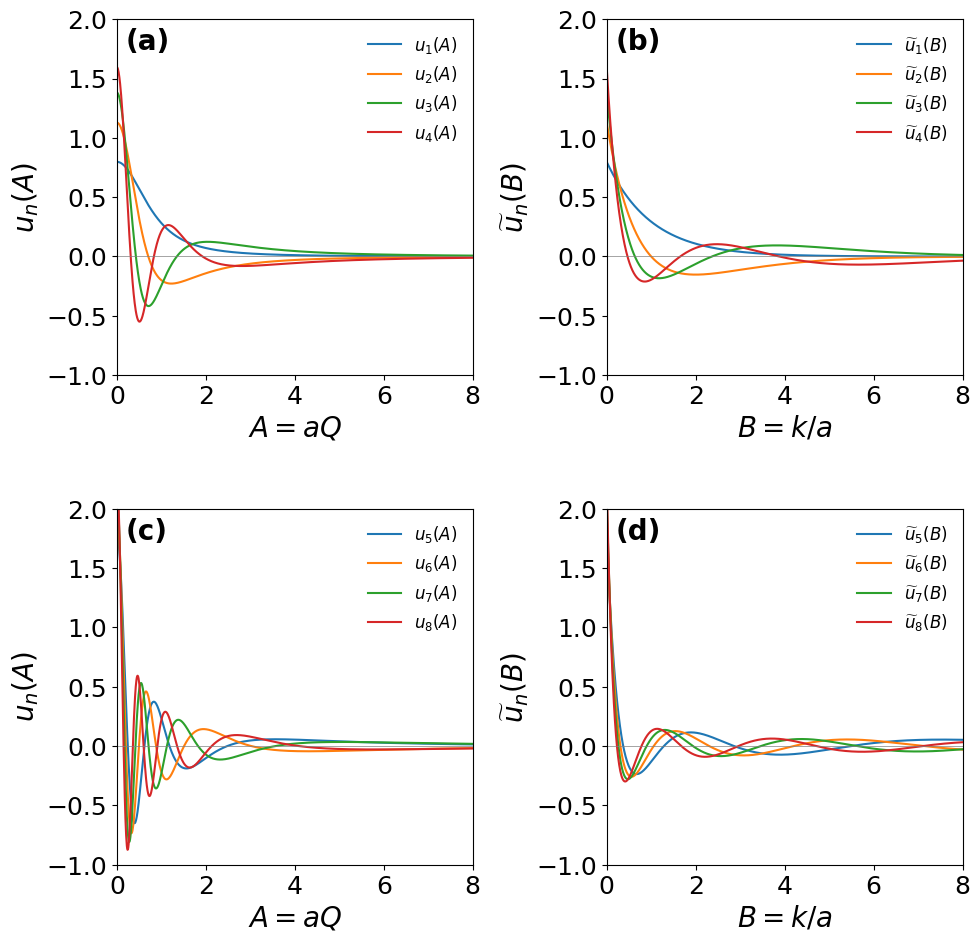

In [3]:
# Axes grids
A = np.linspace(1e-3, 8, 1000)
B = np.linspace(1e-3, 8, 1000)  # avoid B=0 for K_n

# Plot
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
panel_labels = ['(a)', '(b)', '(c)', '(d)']
for ax, label in zip(axs.flat, panel_labels):
    ax.text(0.025, 0.975, label, transform=ax.transAxes,
            fontsize=20, fontweight='bold', va='top', ha='left')
    
b = 3/2  # half-integer case for testing

# Upper left: u_n(A) for n=1 to 4
for n in range(1, 5):
    uA = u_n_A(n, A, b=b)
    uA = uA*np.sign(uA[0])
    axs[0, 0].plot(A, uA, label=fr'$u_{{{n}}}(A)$')
axs[0, 0].axhline(color='gray', linestyle='-', linewidth=0.5)
axs[0, 0].set_xlabel(r'$A=aQ$', fontsize=20)
axs[0, 0].set_ylabel(r'$u_n(A)$', fontsize=20)
axs[0, 0].tick_params(axis='both', which='major', labelsize=18)
axs[0, 0].legend(fontsize=12, frameon=False)
axs[0, 0].set_ylim([-1, 2])
axs[0, 0].set_xlim([0, 8])
axs[0, 0].set_aspect(8/3)

# Upper right: \tilde u_n(B) for n=1 to 4
for n in range(1, 5):
    uB = u_tilde_n_B(n, B, b=b)
    uB = uB*np.sign(uB[0])
    axs[0, 1].plot(B, uB, label=fr'$\widetilde{{u}}_{{{n}}}(B)$')
axs[0, 1].axhline(color='gray', linestyle='-', linewidth=0.5)
axs[0, 1].set_xlabel(r'$B=k/a$', fontsize=20)
axs[0, 1].set_ylabel(r'$\widetilde{u}_n(B)$', fontsize=20)
axs[0, 1].tick_params(axis='both', which='major', labelsize=18)
axs[0, 1].legend(fontsize=12, frameon=False)
axs[0, 1].set_ylim([-1, 2])
axs[0, 1].set_xlim([0, 8])
axs[0, 1].set_aspect(8/3)

# Lower left: u_n(A) for n=5 to 8
for n in range(5, 9):
    uA = u_n_A(n, A, b=b)
    uA = uA*np.sign(uA[0])
    axs[1, 0].plot(A, uA, label=fr'$u_{{{n}}}(A)$')
axs[1, 0].axhline(color='gray', linestyle='-', linewidth=0.5)
axs[1, 0].set_xlabel(r'$A=aQ$', fontsize=20)
axs[1, 0].set_ylabel(r'$u_n(A)$', fontsize=20)
axs[1, 0].tick_params(axis='both', which='major', labelsize=18)
axs[1, 0].legend(fontsize=12, frameon=False)
axs[1, 0].set_ylim([-1, 2])
axs[1, 0].set_xlim([0, 8])
axs[1, 0].set_aspect(8/3)

# Lower right: \tilde u_n(B) for n=5 to 8
for n in range(5, 9):
    uB = u_tilde_n_B(n, B, b=b)
    uB = uB*np.sign(uB[0])
    axs[1, 1].plot(B, uB, label=fr'$\widetilde{{u}}_{{{n}}}(B)$')
axs[1, 1].axhline(color='gray', linestyle='-', linewidth=0.5)
axs[1, 1].set_xlabel(r'$B=k/a$', fontsize=20)
axs[1, 1].set_ylabel(r'$\widetilde{u}_n(B)$', fontsize=20)
axs[1, 1].tick_params(axis='both', which='major', labelsize=18)
axs[1, 1].legend(fontsize=12, frameon=False)
axs[1, 1].set_ylim([-1, 2])
axs[1, 1].set_xlim([0, 8])
axs[1, 1].set_aspect(8/3)

plt.tight_layout(pad=1.5)
plt.show()

## check basis Hankel transform

(0.0, 8.0)

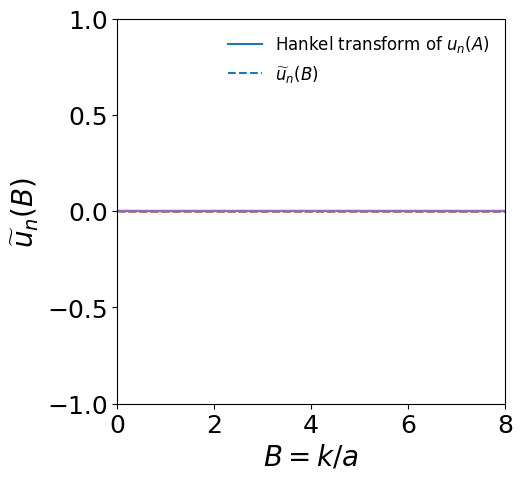

In [4]:
import numpy as np
from scipy.integrate import simpson
from scipy import special

def hankel0_simpson_grid(A, fA, B):
    """
    u(B) = ∫ A f(A) J0(A B) dA   using vectorized Simpson over A-grid.

    A : (NA,) increasing
    fA: (NA,) values f(A)
    B : (NB,) points where you want u(B)
    returns uB: (NB,)
    """
    A  = np.asarray(A, float)
    fA = np.asarray(fA, float)
    B  = np.asarray(B, float)

    if A.ndim != 1 or B.ndim != 1:
        raise ValueError("A and B must be 1D arrays.")
    if A.size != fA.size:
        raise ValueError("A and fA must have the same length.")
    if np.any(np.diff(A) <= 0):
        raise ValueError("A must be strictly increasing.")

    gA = A * fA                                    # (NA,)
    J  = special.j0(np.outer(A, B))                 # (NA, NB)
    integrand = gA[:, None] * J                     # (NA, NB)
    return simpson(integrand, x=A, axis=0)          # (NB,)

# check, plot the Hankel transform relation between u_n(A) and u_tilde_n(B)
# Axes grids
A = np.linspace(0, 1000, 20000)
B = np.linspace(1e-3, 100, 1000)  # avoid B=0 for K_n

# Plot
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# Upper left: u_n(A) for n=1 to 5
for i_n, n in enumerate(range(1, 6)):
    uA = u_n_A(n, A, b=3/2)
    
    if i_n == 0:
        label_A = r'Hankel transform of $u_{{{n}}}(A)$'
        label_B = r'$\widetilde{{u}}_{{{n}}}(B)$'
    else:
        label_A = None
        label_B = None
    
    # Hankel transform of u_n(A)
    uB_HT = hankel0_simpson_grid(A, uA, B) 
    line = ax.plot(B, uB_HT-uB_HT, '-', label=label_A)
    
    # Direct evaluation of u_tilde_n(B)
    uB = u_tilde_n_B(n, B, b=3/2) 
    ax.plot(B, uB-uB_HT, '--', label=label_B, color=line[0].get_color())
    
ax.set_xlim([1e-3, 8])
ax.set_ylim([-1e-1, 1e-1])

ax.set_xlabel(r'$B=k/a$', fontsize=20)
ax.set_ylabel(r'$\widetilde{u}_n(B)$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.legend(fontsize=12, frameon=False)
ax.set_ylim([-1, 1])
ax.set_xlim([0, 8])

# ax.set_xscale('log')

# expansion coefficients

## model functions

In [24]:
def debye_scattering(Q, Rg):
    """
    Debye function for Gaussian chain, normalized so f(0)=1.
    Works for scalar Q or array Q.
    Returns an array for array input and a float for float input.
    """
    Q = np.asarray(Q, dtype=float)
    u = (Q * float(Rg))**2

    # allocate array
    out = np.empty_like(u, dtype=float)

    small = u < 1e-6
    us = u[small]
    out[small] = 1.0 - us/3.0 + us**2/12.0 - us**3/60.0

    ub = u[~small]
    out[~small] = 2.0 * (np.exp(-ub) - 1.0 + ub) / (ub**2)

    # return scalar if scalar input
    if out.shape == ():
        return float(out)
    return out

def fuzzy_ball(Q, R, s):
    Qs = Q*s
    QR = Q*R
    return 9 * (np.sin(QR) - QR * np.cos(QR))**2 / (QR)**6 * np.exp(-Qs ** 2 / 2)

## coefficient extraction

In [25]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import quad
from scipy.special import j0
from scipy.interpolate import interp1d

# ============================================================
# 1) estimate a scale 'a' from observed (Q, f(Q)) by locating a knee:
# ============================================================
def estimate_a_from_knee(Q_grid, fQ_grid, b=1.0, frac=0.5, n0=10):
    """
    Estimate a scale 'a' from observed (Q, f(Q)) by locating a knee:
      find Q* where f(Q*) = frac * f0, with f0 ~ median of first n0 points.

    Then match the width to (1 + a^2 Q^2)^(-b):
      a = (1/Q*) * sqrt(frac^(-1/b) - 1).

    Parameters
    ----------
    Q_grid : array-like, positive, increasing
    fQ_grid : array-like, same shape
    b : float
        Basis shape parameter (>0).
    frac : float
        Target fraction of the low-Q baseline (0<frac<1). Default 0.5.
    n0 : int
        Number of first points used to estimate baseline.

    Returns
    -------
    a_est : float
    Q_star : float
    f0 : float
    """
    Q = np.asarray(Q_grid, float)
    f = np.asarray(fQ_grid, float)

    if Q.ndim != 1 or f.shape != Q.shape:
        raise ValueError("Q_grid and fQ_grid must be 1D arrays with the same shape.")
    if np.any(Q <= 0):
        raise ValueError("Q_grid must be positive.")
    if not np.all(np.diff(Q) > 0):
        raise ValueError("Q_grid must be strictly increasing.")
    if not (0.0 < frac < 1.0):
        raise ValueError("frac must be in (0,1).")
    b = float(b)
    if not (b > 0):
        raise ValueError("b must be > 0.")

    n0 = int(min(max(n0, 2), len(Q)))
    f0 = float(np.median(f[:n0]))
    target = frac * f0

    f_s = f.copy()

    idx = np.where(f_s <= target)[0]
    if len(idx) == 0:
        # no knee within range -> fall back to geometric-midpoint in Q
        Q_star = float(np.sqrt(Q[0] * Q[-1]))
        # knee-match formula still needs a Q_star; use it
        a_est = (1.0 / Q_star) * np.sqrt(frac ** (-1.0 / b) - 1.0)
        return float(a_est), float(Q_star), f0

    i = int(idx[0])
    if i == 0:
        Q_star = float(Q[0])
        a_est = (1.0 / Q_star) * np.sqrt(frac ** (-1.0 / b) - 1.0)
        return float(a_est), float(Q_star), f0

    # interpolate knee location in logQ (stable for log-spaced grids)
    q1, q2 = Q[i - 1], Q[i]
    y1, y2 = f_s[i - 1], f_s[i]
    if y2 == y1:
        Q_star = float(q2)
    else:
        t = (target - y1) / (y2 - y1)
        logQ_star = np.log(q1) + (np.log(q2) - np.log(q1)) * t
        Q_star = float(np.exp(logQ_star))

    a_est = (1.0 / Q_star) * np.sqrt(frac ** (-1.0 / b) - 1.0)
    return float(a_est), float(Q_star), f0


# ============================================================
# 2) Projection onto your basis u_n_Q (assumed defined elsewhere)
#    a_n = ∫ f(Q) u_n(Q) 2πQ dQ
# ============================================================
def get_expansion_coefficients(
    fQ,
    n_max: int,
    a: float,
    Q_limit: float,
    b: float = 1.0,              # <-- NEW
    quad_limit: int = 200,
    epsabs: float = 1e-12,
    epsrel: float = 1e-10,
    mode: str = "split",          # "split" or "log"
    Q0: float | None = None,      # optional split point for "split" mode
    n_splits: int = 4,            # number of sub-intervals in "split" mode
):
    """
    Compute coefficients
        a_n = ∫_0^{Q_limit} f(Q) u_n(Q; a,b) (2πQ) dQ
    using scipy.integrate.quad.

    Parameters
    ----------
    fQ : callable(Q)->float
        Scalar-safe function f(Q).
    n_max : int
        Maximum basis index n (computes n=1..n_max).
    a : float
        Basis scale parameter used by u_n_Q.
    Q_limit : float
        Upper integration limit in Q.
    b : float
        Basis shape parameter (supports half-integers/integers if your u_n_Q does).
    quad_limit : int
        quad recursion limit.
    epsabs, epsrel : float
        Absolute/relative error tolerances passed to quad.
    mode : str
        "split": integrate over Q with sub-intervals (recommended default).
        "log":   integrate using Q = exp(t), t ∈ (-∞, log Q_limit], with Q clipped at Q_min.
    Q0 : float or None
        For "split" mode, optional characteristic split location. If None, uses Q0=1/a.
    n_splits : int
        For "split" mode, number of sub-intervals between 0 and Q_limit.

    Returns
    -------
    coeffs : (n_max,) ndarray
        Coefficients a_n for n=1..n_max.
    errs : (n_max,) ndarray
        quad error estimates for each coefficient.
    """
    if int(n_max) != n_max or n_max < 1:
        raise ValueError("n_max must be an integer >= 1.")
    n_max = int(n_max)

    a = float(a)
    Q_limit = float(Q_limit)
    if not (Q_limit > 0):
        raise ValueError("Q_limit must be > 0.")
    if a <= 0:
        raise ValueError("a must be > 0.")

    # choose a characteristic split scale near where x=1/(1+(aQ)^2) transitions
    if Q0 is None:
        Q0 = 1.0 / a
    Q0 = float(Q0)

    coeffs = np.zeros(n_max, dtype=float)
    errs   = np.zeros(n_max, dtype=float)

    two_pi = 2.0 * np.pi

    if mode not in ("split", "log"):
        raise ValueError("mode must be 'split' or 'log'.")

    # ---- helper: integrate a scalar integrand over multiple sub-intervals ----
    def _quad_piecewise(integrand, edges):
        total = 0.0
        total_err = 0.0
        for lo, hi in zip(edges[:-1], edges[1:]):
            if hi <= lo:
                continue
            val, err = quad(
                integrand, lo, hi,
                limit=quad_limit,
                epsabs=epsabs, epsrel=epsrel
            )
            total += val
            total_err += err
        return total, total_err

    # ---- choose sub-interval edges for split mode ----
    if mode == "split":
        Q_mid = min(Q0, Q_limit)
        if Q_mid <= 0:
            Q_mid = min(Q_limit, 1.0)

        linear_edges = np.linspace(0.0, Q_mid, max(2, n_splits + 1))

        if Q_limit > Q_mid:
            log_edges = np.geomspace(max(Q_mid, 1e-300), Q_limit, max(2, n_splits + 1))
            edges = np.unique(np.concatenate([linear_edges, log_edges]))
        else:
            edges = linear_edges

        edges[0] = 0.0
        edges[-1] = Q_limit

        for n in range(1, n_max + 1):
            def integrand(Q, n=n):  # bind n to avoid late-binding gotchas
                return fQ(Q) * u_n_Q(n, Q, a, b=b) * (two_pi * Q)

            val, err = _quad_piecewise(integrand, edges)
            coeffs[n - 1] = val
            errs[n - 1] = err

        return coeffs, errs

    # ---- log mode: Q = exp(t) with t in [t_min, log(Q_limit)] ----
    Q_min = min(1e-12 / a, 1e-12)
    t_hi = np.log(Q_limit)
    t_lo = np.log(Q_min)

    for n in range(1, n_max + 1):
        def integrand_t(t, n=n):
            Q = np.exp(t)
            # dQ = Q dt, and measure is 2π Q dQ = 2π Q^2 dt
            return fQ(Q) * u_n_Q(n, Q, a, b=b) * (two_pi * Q * Q)

        val, err = quad(
            integrand_t, t_lo, t_hi,
            limit=quad_limit,
            epsabs=epsabs, epsrel=epsrel
        )
        coeffs[n - 1] = val
        errs[n - 1] = err

    return coeffs, errs
    
def reconstruct_from_coeffs(Q_grid, coeffs, a, errs=None, b=1.0):
    """
    Reconstruct f(Q) = sum_n a_n u_n(Q; a,b).

    If errs is provided, also return propagated pointwise error assuming
    uncorrelated coefficient uncertainties:
        var[f(Q)] = sum_n errs[n]^2 * u_n(Q)^2

    Parameters
    ----------
    Q_grid : array-like
    coeffs : array-like, shape (n_max,)
        Expansion coefficients a_n.
    a : float
        Basis scale parameter.
    errs : array-like or None
        Standard deviations of coefficients a_n.
    b : float
        Basis shape parameter (passed to u_n_Q).

    Returns
    -------
    out : ndarray
        Reconstructed f(Q).
    out_err : ndarray (only if errs is not None)
        Propagated standard deviation at each Q.
    """
    Q_grid = np.asarray(Q_grid, float)
    coeffs = np.asarray(coeffs, float)

    out = np.zeros_like(Q_grid)
    out_var = np.zeros_like(Q_grid) if errs is not None else None

    if errs is not None:
        errs = np.asarray(errs, float)
        if errs.shape != coeffs.shape:
            raise ValueError("errs must have the same shape as coeffs.")

    for i, ai in enumerate(coeffs, start=1):
        ui = u_n_Q(i, Q_grid, a, b=b)
        out += ai * ui
        if errs is not None:
            out_var += (errs[i - 1] * ui) ** 2

    if errs is not None:
        return out, np.sqrt(out_var)
    return out


# ============================================================
# 3) Expansion of the self-convolution (f*f)(Q) in the u_n basis
# ============================================================
from scipy import special

def build_f_nconv(
    fQ,
    a: float,
    n_conv: int = 2,
    Q_min: float = 1e-3,
    Q_max: float = 1e3,
    NQ: int = 3000,
    NB: int = 3000,
    chunk_B: int = 64,
    chunk_A: int = 4096,
    # ---------------------------
    # Normalization options
    # ---------------------------
    normalize_input: bool = False,
    normalize_output: bool = False,
    norm_kind: str = "integral",
    norm_domain: str = "Q",
    norm_measure: str = "plain",
    norm_eps: float = 1e-300,
):
    a = float(a)
    if a <= 0:
        raise ValueError("a must be > 0.")
    if int(n_conv) != n_conv or n_conv < 1:
        raise ValueError("n_conv must be an integer >= 1.")
    n_conv = int(n_conv)

    if norm_kind not in ("integral", "squared"):
        raise ValueError("norm_kind must be 'integral' or 'squared'.")
    if norm_domain not in ("Q", "A"):
        raise ValueError("norm_domain must be 'Q' or 'A'.")
    if norm_measure not in ("plain", "radial"):
        raise ValueError("norm_measure must be 'plain' or 'radial'.")

    # ---------------------------
    # Internal grids
    # ---------------------------
    NQ = int(NQ)
    NB = int(NB)
    if NQ < 4 or NB < 4:
        raise ValueError("NQ and NB should be reasonably large (>=4).")

    # Positive Q grid + explicit Q=0 point
    Q_pos  = np.logspace(np.log10(Q_min), np.log10(Q_max), NQ - 1)
    Q_grid = np.concatenate(([0.0], Q_pos))
    A_grid = a * Q_grid

    # B grid: include B=0 explicitly, and IMPORTANTLY use first positive A for B_max
    A_min_pos = max(A_grid[1], 1e-300)        # <-- critical fix
    B_min = 1.0 / max(A_grid[-1], 1e-300)
    B_max = 1.0 / A_min_pos

    B_pos  = np.logspace(np.log10(B_min), np.log10(B_max), NB - 1)
    B_grid = np.concatenate(([0.0], B_pos))

    # trapezoid weights on generic grid x
    def trapz_weights(x):
        x = np.asarray(x, float)
        w = np.zeros_like(x)
        w[1:-1] = 0.5 * (x[2:] - x[:-2])
        w[0]    = 0.5 * (x[1] - x[0])
        w[-1]   = 0.5 * (x[-1] - x[-2])
        return w

    wA = trapz_weights(A_grid)
    wB = trapz_weights(B_grid)

    # --------- normalization helper (on the internal grid) ---------
    def _compute_scale(f_vals):
        if norm_domain == "Q":
            x = Q_grid
            w = Q_grid if norm_measure == "radial" else 1.0
        else:
            x = A_grid
            w = A_grid if norm_measure == "radial" else 1.0

        if norm_kind == "integral":
            I = float(np.trapz(w * f_vals, x))
            if abs(I) <= norm_eps:
                raise ValueError(f"Normalization integral too small (I={I}).")
            return 1.0 / I, I
        else:
            I = float(np.trapz(w * (f_vals * f_vals), x))
            if I <= norm_eps:
                raise ValueError(f"Normalization squared-integral too small (I={I}).")
            return 1.0 / np.sqrt(I), I

    # sample f on Q_grid (scalar-safe calls), with safe Q=0 handling
    f_vals = np.empty_like(Q_grid)
    # Q=0
    try:
        f0 = float(fQ(0.0))
        if not np.isfinite(f0):
            raise ValueError
    except Exception:
        f0 = float(fQ(float(Q_grid[1])))   # fallback
    f_vals[0] = f0

    # Q>0
    for i in range(1, len(Q_grid)):
        f_vals[i] = float(fQ(float(Q_grid[i])))

    input_scale = 1.0
    input_I = None
    if normalize_input:
        input_scale, input_I = _compute_scale(f_vals)
        f_vals = input_scale * f_vals

    # ---------- forward transform f_hat(B) ----------
    # f̂(aB) = (1/a^2) ∫ A dA J0(BA) f(A/a)
    IA = (A_grid * f_vals) * wA

    f_opt = np.zeros_like(B_grid)
    for b0 in range(0, NB, chunk_B):
        b1 = min(NB, b0 + chunk_B)
        Bb = B_grid[b0:b1]

        acc = np.zeros(b1 - b0, dtype=float)
        for a0 in range(0, NQ, chunk_A):
            a1 = min(NQ, a0 + chunk_A)
            Aa = A_grid[a0:a1]
            Jblk = special.j0(np.outer(Bb, Aa))
            acc += Jblk @ IA[a0:a1]

        f_opt[b0:b1] = (1.0 / (a * a)) * acc

    # ---------- inverse transform for n-fold convolution ----------
    Fn = f_opt ** n_conv
    IB = (B_grid * Fn) * wB

    # f^{(*n)}(Q) = (2π)^{n-1} ∫ k dk J0(kQ) [f̂(k)]^n
    # with k=aB, dk=a dB -> factor a^2
    factor = (2.0 * np.pi) ** (n_conv - 1) * (a * a)

    f_n_grid = np.zeros_like(Q_grid)
    for a0 in range(0, NQ, chunk_A):
        a1 = min(NQ, a0 + chunk_A)
        Aa = A_grid[a0:a1]

        acc = np.zeros(a1 - a0, dtype=float)
        for b0 in range(0, NB, chunk_B):
            b1 = min(NB, b0 + chunk_B)
            Bb = B_grid[b0:b1]
            Jblk = special.j0(np.outer(Bb, Aa))
            acc += (Jblk.T @ IB[b0:b1])

        f_n_grid[a0:a1] = factor * acc

    output_scale = 1.0
    output_I = None
    if normalize_output:
        output_scale, output_I = _compute_scale(f_n_grid)
        f_n_grid = output_scale * f_n_grid

    # ---------- Q-only callable via log-Q interpolation (positive part) ----------
    logQ_pos = np.log(Q_pos)          # no log(0)
    f_pos    = f_n_grid[1:]           # align with Q_pos

    def f_nQ(Q):
        Q_arr = np.asarray(Q, dtype=float)
        if np.any(Q_arr < 0):
            raise ValueError("Q must be >= 0.")
        # handle scalar Q=0
        if Q_arr.shape == () and Q_arr == 0.0:
            return float(f_n_grid[0])

        Qc = np.clip(Q_arr, Q_pos[0], Q_pos[-1])
        y = np.interp(np.log(Qc), logQ_pos, f_pos)

        # restore exact zeros if present in array input
        if Q_arr.shape != ():
            y = np.asarray(y)
            y = np.where(Q_arr == 0.0, f_n_grid[0], y)
        return float(y) if np.asarray(y).shape == () else y

    meta = {
        "a": a,
        "n_conv": n_conv,
        "Q_grid": Q_grid,
        "A_grid": A_grid,
        "B_grid": B_grid,
        "f_opt_B": f_hat,
        "f_n_grid": f_n_grid,
        "normalize_input": normalize_input,
        "normalize_output": normalize_output,
        "norm_kind": norm_kind,
        "norm_domain": norm_domain,
        "norm_measure": norm_measure,
        "input_scale": float(input_scale),
        "input_I": None if input_I is None else float(input_I),
        "output_scale": float(output_scale),
        "output_I": None if output_I is None else float(output_I),
        "B_min": float(B_min),
        "B_max": float(B_max),
    }
    return f_nQ, meta

def compute_normalization(
    f, Q,
    a: float = 1.0,
    kind: str = "integral",     # "integral" or "squared"
    domain: str = "Q",          # "Q" or "A"
    measure: str = "plain",     # "plain" or "radial"
    include_2pi: bool = False,  # if True and measure="radial", uses 2πQ dQ (or 2πA dA)
    eps: float = 1e-300
):
    """
    Compute normalization scale for f sampled on grid Q.

    kind:
        "integral": enforce ∫ (...) = 1
        "squared":  enforce ∫ (...) = 1 for f^2
    domain:
        "Q": integrate over Q
        "A": integrate over A = aQ
    measure:
        "plain":  dQ or dA
        "radial": Q dQ or A dA
    include_2pi:
        If True and measure="radial", uses 2πQ dQ (or 2πA dA), i.e. plane integral.

    Returns
    -------
    scale : float
        Multiply f by this to achieve the chosen normalization.
    I : float
        The original integral (before scaling).
    """
    Q = np.asarray(Q, float)
    f = np.asarray(f, float)
    if Q.ndim != 1 or f.shape != Q.shape:
        raise ValueError("Q and f must be 1D arrays with the same shape.")
    if np.any(Q <= 0) or not np.all(np.diff(Q) > 0):
        raise ValueError("Q must be positive and strictly increasing.")

    a = float(a)
    if a <= 0:
        raise ValueError("a must be > 0.")

    if kind not in ("integral", "squared"):
        raise ValueError("kind must be 'integral' or 'squared'.")
    if domain not in ("Q", "A"):
        raise ValueError("domain must be 'Q' or 'A'.")
    if measure not in ("plain", "radial"):
        raise ValueError("measure must be 'plain' or 'radial'.")

    if domain == "Q":
        x = Q
        w = Q if measure == "radial" else 1.0
    else:
        x = a * Q
        w = (a * Q) if measure == "radial" else 1.0

    if include_2pi and measure == "radial":
        w = (2.0 * np.pi) * w

    if kind == "integral":
        integrand = w * f
        I = float(np.trapz(integrand, x))
        if abs(I) <= eps:
            raise ValueError(f"Normalization integral too small (I={I}).")
        return 1.0 / I, I

    integrand = w * (f * f)
    I = float(np.trapz(integrand, x))
    if I <= eps:
        raise ValueError(f"Normalization squared-integral too small (I={I}).")
    return 1.0 / np.sqrt(I), I



## test expansion and reconstruction

scale = 3.276123e-01, original integral = 3.052388e+00 (∫ 2π Q f(Q) dQ)
fQ normalization factor = 1.000000e+00, fQ integral = 1.000000e+00
0.9628919828299252


/tmp/ipykernel_2507886/2430598660.py:169: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  val, err = quad(
/tmp/ipykernel_2507886/2430598660.py:169: IntegrationWarning: The maximum number of subdivisions (300) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  val, err = quad(


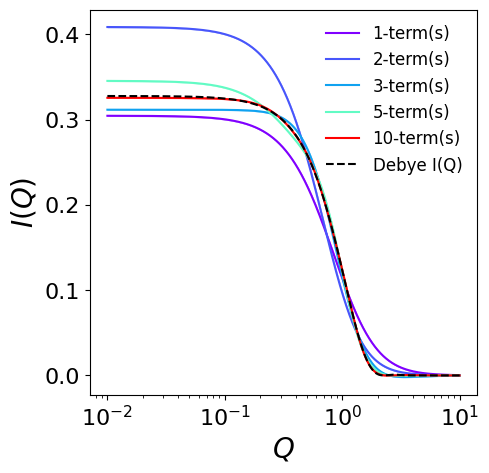

In [26]:
## prepare scattering function and normalization
Rg = 1
# scattering function
# not yet normalized by probability measure, i.e. plain f(Q)
# def fQ_raw(Q): 
#     return debye_scattering(Q, Rg)

def fQ_raw(Q):
    return fuzzy_ball(Q, R=Rg*2, s=Rg/2)

# grid for plotting / normalization
Q_grid = np.logspace(-2, 1, 2500)
fQ_raw_grid = fQ_raw(Q_grid)

# choose normalization convention
norm_kind   = "integral"
norm_domain = "Q"
norm_measure= "radial"

# build normalized probability density 
scale, I0 = compute_normalization(fQ_raw_grid, Q_grid,
                                  kind=norm_kind, domain=norm_domain, measure=norm_measure, include_2pi=True)
print(f"scale = {scale:.6e}, original integral = {I0:.6e} (∫ 2π Q f(Q) dQ)")

def fQ(Q):
    return scale * fQ_raw(Q)
fQ_grid = fQ(Q_grid)

scale_fQ, I0 = compute_normalization(fQ_grid, Q_grid, 
                                     kind=norm_kind, domain=norm_domain, measure=norm_measure, include_2pi=True)
print(f"fQ normalization factor = {scale_fQ:.6e}, fQ integral = {I0:.6e}")

## tests
# ============================================================
# 2) Projection onto your basis u_n_Q (assumed defined elsewhere)
#    a_n = ∫ f(Q) u_n(Q) 2πQ dQ
# ============================================================

b = 3/2
# # for Gaussian chain, a=Rg/sqrt(3*b) is a natural scale for the basis
# a = Rg / np.sqrt(3*b)

a_est, Q_star, f0 = estimate_a_from_knee(Q_grid, fQ_grid, b=b, frac=np.exp(-1))
a = a_est
print(a)
    
n_max = 20 # number of basis functions to project onto
Q_limit = Q_grid[-1]  # integrate up to the same max Q as your plotted grid

coeffs, errs = get_expansion_coefficients(
    fQ,
    n_max=n_max,
    a=a,
    b=b,
    Q_limit=Q_limit,
    quad_limit=300,
    epsabs=1e-10,
    epsrel=1e-10,
    mode="split",
    n_splits=4
)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plotting_n_max = 10
plotting_n_list = [1, 2, 3, 5, 10]
colors = plt.cm.rainbow(np.linspace(0, 1, plotting_n_max))
for i, (ci, ei) in enumerate(zip(coeffs, errs), start=1):
    if i not in plotting_n_list:
        continue
    fQ_rec, fQ_err = reconstruct_from_coeffs(Q_grid, coeffs[:i], a, b=b, errs=errs[:i])
    ax.plot(Q_grid, fQ_rec, '-', label=f'{i}-term(s)', color =colors[i-1])
    ax.fill_between(Q_grid, fQ_rec - fQ_err, fQ_rec + fQ_err, alpha=0.3, color=colors[i-1])
    
ax.plot(Q_grid, fQ_grid, '--', label='Debye I(Q)', color='black')

ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel(r'$Q$', fontsize=20)
ax.set_ylabel(r'$I(Q)$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=12, frameon=False)
plt.show()

## test reconstruct convolved curve

/tmp/ipykernel_2507886/2864527862.py:28: RuntimeWarning: invalid value encountered in scalar divide
  return 9 * (np.sin(QR) - QR * np.cos(QR))**2 / (QR)**6 * np.exp(-Qs ** 2 / 2)


fQ normalization factor = 9.998334e-01, fQ integral = 1.000167e+00


/tmp/ipykernel_2507886/2430598660.py:169: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  val, err = quad(
/tmp/ipykernel_2507886/2430598660.py:169: IntegrationWarning: The maximum number of subdivisions (300) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  val, err = quad(


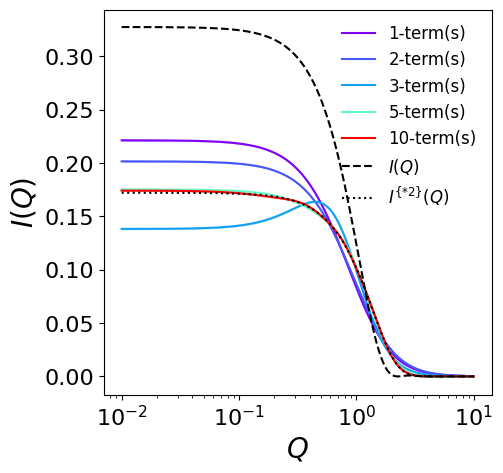

In [27]:
# tests
# ============================================================
# 3) Expansion of the self-convolution (f*f)(Q) in the u_n basis
# ============================================================
f2Q, meta = build_f_nconv(
    fQ,
    n_conv=2,
    a=a,
    Q_min=1e-2,
    Q_max=1e2,
    NQ=2000,
    NB=2000,
    normalize_input=False,
    normalize_output=False,
    norm_kind=norm_kind,
    norm_domain=norm_domain,
    norm_measure=norm_measure,
)

f2Q_grid = f2Q(Q_grid)

# check normalization of f2Q
scale_f2Q, I0 = compute_normalization(f2Q_grid, Q_grid, 
                                     kind=norm_kind, domain=norm_domain, measure=norm_measure, include_2pi=True)
print(f"fQ normalization factor = {scale_f2Q:.6e}, fQ integral = {I0:.6e}")

n_max = 20 # number of basis functions to project onto
Q_limit = Q_grid[-1]  # integrate up to the same max Q as your plotted grid

coeffs_2, errs_2 = get_expansion_coefficients(
    f2Q,
    n_max=n_max,
    a=a,
    b=b,
    Q_limit=Q_limit,
    quad_limit=300,
    epsabs=1e-12,
    epsrel=1e-10,
    mode="split",
    n_splits=4
)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plotting_n_max = 10
plotting_n_list = [1, 2, 3, 5, 10]
colors = plt.cm.rainbow(np.linspace(0, 1, plotting_n_max))
for i, (ci, ei) in enumerate(zip(coeffs_2, errs_2), start=1):
    if i not in plotting_n_list:
        continue
    fQ_rec, fQ_err = reconstruct_from_coeffs(Q_grid, coeffs_2[:i], a, b=b, errs=errs_2[:i])
    ax.plot(Q_grid, fQ_rec, '-', label=f'{i}-term(s)', color =colors[i-1])
    ax.fill_between(Q_grid, fQ_rec - fQ_err, fQ_rec + fQ_err, alpha=0.3, color=colors[i-1])
    
ax.plot(Q_grid, fQ_grid, '--', label=r'$I(Q)$', color='black')
ax.plot(Q_grid, f2Q_grid, ':', label=r'$I^{\{*2\}}(Q)$', color='black')

ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel(r'$Q$', fontsize=20)
ax.set_ylabel(r'$I(Q)$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=12, frameon=False)
plt.show()

/tmp/ipykernel_2507886/2864527862.py:28: RuntimeWarning: invalid value encountered in scalar divide
  return 9 * (np.sin(QR) - QR * np.cos(QR))**2 / (QR)**6 * np.exp(-Qs ** 2 / 2)


fQ normalization factor = 9.997107e-01, fQ integral = 1.000289e+00


/tmp/ipykernel_2507886/2430598660.py:169: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  val, err = quad(
/tmp/ipykernel_2507886/2430598660.py:169: IntegrationWarning: The maximum number of subdivisions (300) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  val, err = quad(


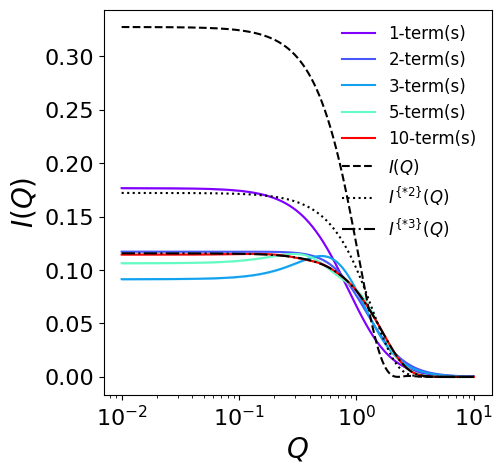

In [28]:
# tests
# ============================================================
# 3) Expansion of the self-convolution (f*f)(Q) in the u_n basis
# ============================================================
f3Q, meta = build_f_nconv(
    fQ,
    n_conv=3,
    a=a,
    Q_min=1e-2,
    Q_max=1e2,
    NQ=2000,
    NB=2000,
    normalize_input=False,
    normalize_output=False,
    norm_kind=norm_kind,
    norm_domain=norm_domain,
    norm_measure=norm_measure,
)

f3Q_grid = f3Q(Q_grid)

# check normalization of f3Q
scale_f3Q, I0 = compute_normalization(f3Q_grid, Q_grid, 
                                     kind=norm_kind, domain=norm_domain, measure=norm_measure, include_2pi=True)
print(f"fQ normalization factor = {scale_f3Q:.6e}, fQ integral = {I0:.6e}")

n_max = 20 # number of basis functions to project onto
Q_limit = Q_grid[-1]  # integrate up to the same max Q as your plotted grid

coeffs_3, errs_3 = get_expansion_coefficients(
    f3Q,
    n_max=n_max,
    a=a,
    b=b,
    Q_limit=Q_limit,
    quad_limit=300,
    epsabs=1e-12,
    epsrel=1e-10,
    mode="split",
    n_splits=4
)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plotting_n_max = 10
plotting_n_list = [1, 2, 3, 5, 10]
colors = plt.cm.rainbow(np.linspace(0, 1, plotting_n_max))
for i, (ci, ei) in enumerate(zip(coeffs_3, errs_3), start=1):
    if i not in plotting_n_list:
        continue
    fQ_rec, fQ_err = reconstruct_from_coeffs(Q_grid, coeffs_3[:i], a, b=b, errs=errs_3[:i])
    ax.plot(Q_grid, fQ_rec, '-', label=f'{i}-term(s)', color =colors[i-1])
    ax.fill_between(Q_grid, fQ_rec - fQ_err, fQ_rec + fQ_err, alpha=0.3, color=colors[i-1])
    
ax.plot(Q_grid, fQ_grid, '--', label=r'$I(Q)$', color='black')
ax.plot(Q_grid, f2Q_grid, ':', label=r'$I^{\{*2\}}(Q)$', color='black')
ax.plot(Q_grid, f3Q_grid, '-.', label=r'$I^{\{*3\}}(Q)$', color='black')

ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel(r'$Q$', fontsize=20)
ax.set_ylabel(r'$I(Q)$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=12, frameon=False)
plt.show()

/tmp/ipykernel_2507886/2864527862.py:28: RuntimeWarning: invalid value encountered in scalar divide
  return 9 * (np.sin(QR) - QR * np.cos(QR))**2 / (QR)**6 * np.exp(-Qs ** 2 / 2)


fQ normalization factor = 9.995971e-01, fQ integral = 1.000403e+00


/tmp/ipykernel_2507886/2430598660.py:169: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  val, err = quad(
/tmp/ipykernel_2507886/2430598660.py:169: IntegrationWarning: The maximum number of subdivisions (300) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  val, err = quad(


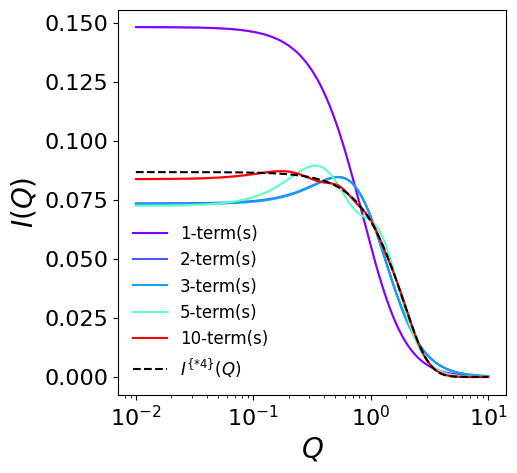

In [29]:
# tests
# ============================================================
# 3) Expansion of the self-convolution (f*f*f*f)(Q) in the u_n basis
# ============================================================
f4Q, meta = build_f_nconv(
    fQ,
    n_conv=4,
    a=a,
    Q_min=1e-2,
    Q_max=1e2,
    NQ=2000,
    NB=2000,
    normalize_input=False,
    normalize_output=False,
    norm_kind=norm_kind,
    norm_domain=norm_domain,
    norm_measure=norm_measure,
)

f4Q_grid = f4Q(Q_grid)

# check normalization of f4Q
scale_f4Q, I0 = compute_normalization(f4Q_grid, Q_grid, 
                                     kind=norm_kind, domain=norm_domain, measure=norm_measure, include_2pi=True)
print(f"fQ normalization factor = {scale_f4Q:.6e}, fQ integral = {I0:.6e}")

n_max = 20 # number of basis functions to project onto
Q_limit = Q_grid[-1]  # integrate up to the same max Q as your plotted grid

coeffs_4, errs_4 = get_expansion_coefficients(
    f4Q,
    n_max=n_max,
    a=a,
    b=b,
    Q_limit=Q_limit,
    quad_limit=300,
    epsabs=1e-12,
    epsrel=1e-10,
    mode="split",
    n_splits=4
)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plotting_n_max = 10
plotting_n_list = [1, 2, 3, 5, 10]
colors = plt.cm.rainbow(np.linspace(0, 1, plotting_n_max))
for i, (ci, ei) in enumerate(zip(coeffs_4, errs_4), start=1):
    if i not in plotting_n_list:
        continue
    fQ_rec, fQ_err = reconstruct_from_coeffs(Q_grid, coeffs_4[:i], a, b=b, errs=errs_4[:i])
    ax.plot(Q_grid, fQ_rec, '-', label=f'{i}-term(s)', color=colors[i-1])
    ax.fill_between(Q_grid, fQ_rec - fQ_err, fQ_rec + fQ_err, alpha=0.3, color=colors[i-1])
    
# ax.plot(Q_grid, fQ_grid, ':', label=r'$I(Q)$', color='black')
# ax.plot(Q_grid, f2Q_grid, ':', label=r'$I^{\{*2\}}(Q)$', color='black')
# ax.plot(Q_grid, f3Q_grid, ':', label=r'$I^{\{*3\}}(Q)$', color='black')
ax.plot(Q_grid, f4Q_grid, '--', label=r'$I^{\{*4\}}(Q)$', color='black')

ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel(r'$Q$', fontsize=20)
ax.set_ylabel(r'$I(Q)$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=12, frameon=False)
plt.show()

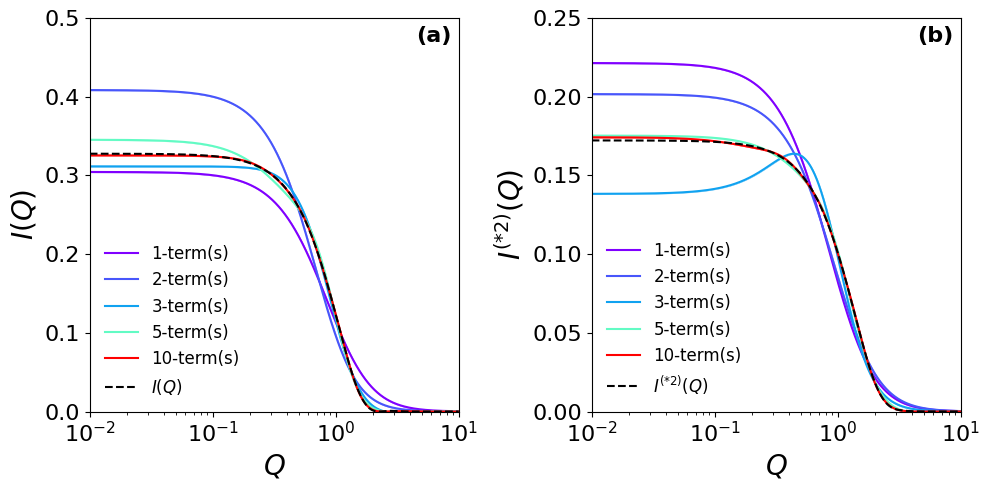

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Left panel: Basis expansion of I(Q)
ax = axs[0]
plotting_n_max = 10
plotting_n_list = [1, 2, 3, 5, 10]
colors = plt.cm.rainbow(np.linspace(0, 1, plotting_n_max))
for i, (ci, ei) in enumerate(zip(coeffs, errs), start=1):
    if i not in plotting_n_list:
        continue
    fQ_rec, fQ_err = reconstruct_from_coeffs(Q_grid, coeffs[:i], a, b=b, errs=errs[:i])
    ax.plot(Q_grid, fQ_rec, '-', label=f'{i}-term(s)', color=colors[i-1])
    ax.fill_between(Q_grid, fQ_rec - fQ_err, fQ_rec + fQ_err, alpha=0.3, color=colors[i-1])
ax.plot(Q_grid, fQ_grid, '--', label=r'$I(Q)$', color='black')
ax.set_xscale('log')
ax.set_xlabel(r'$Q$', fontsize=20)
ax.set_ylabel(r'$I(Q)$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=12, frameon=False)
ax.set_xlim(1e-2, 1e1)
ax.set_ylim(0, 0.5)
ax.text(0.98, 0.98, '(a)', transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# Right panel: Basis expansion of I^{*2}(Q)
ax = axs[1]
for i, (ci, ei) in enumerate(zip(coeffs_2, errs), start=1):
    if i not in plotting_n_list:
        continue
    fQ_rec, fQ_err = reconstruct_from_coeffs(Q_grid, coeffs_2[:i], a, b=b, errs=errs[:i])
    ax.plot(Q_grid, fQ_rec, '-', label=f'{i}-term(s)', color=colors[i-1])
    ax.fill_between(Q_grid, fQ_rec - fQ_err, fQ_rec + fQ_err, alpha=0.3, color=colors[i-1])
ax.plot(Q_grid, f2Q_grid, '--', label=r'$I^{(*2)}(Q)$', color='black')
ax.set_xscale('log')
ax.set_xlabel(r'$Q$', fontsize=20)
ax.set_ylabel(r'$I^{(*2)}(Q)$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=12, frameon=False)
ax.set_xlim(1e-2, 1e1)
ax.set_ylim(0, 0.25)
ax.text(0.98, 0.98, '(b)', transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

plt.tight_layout()
plt.show()

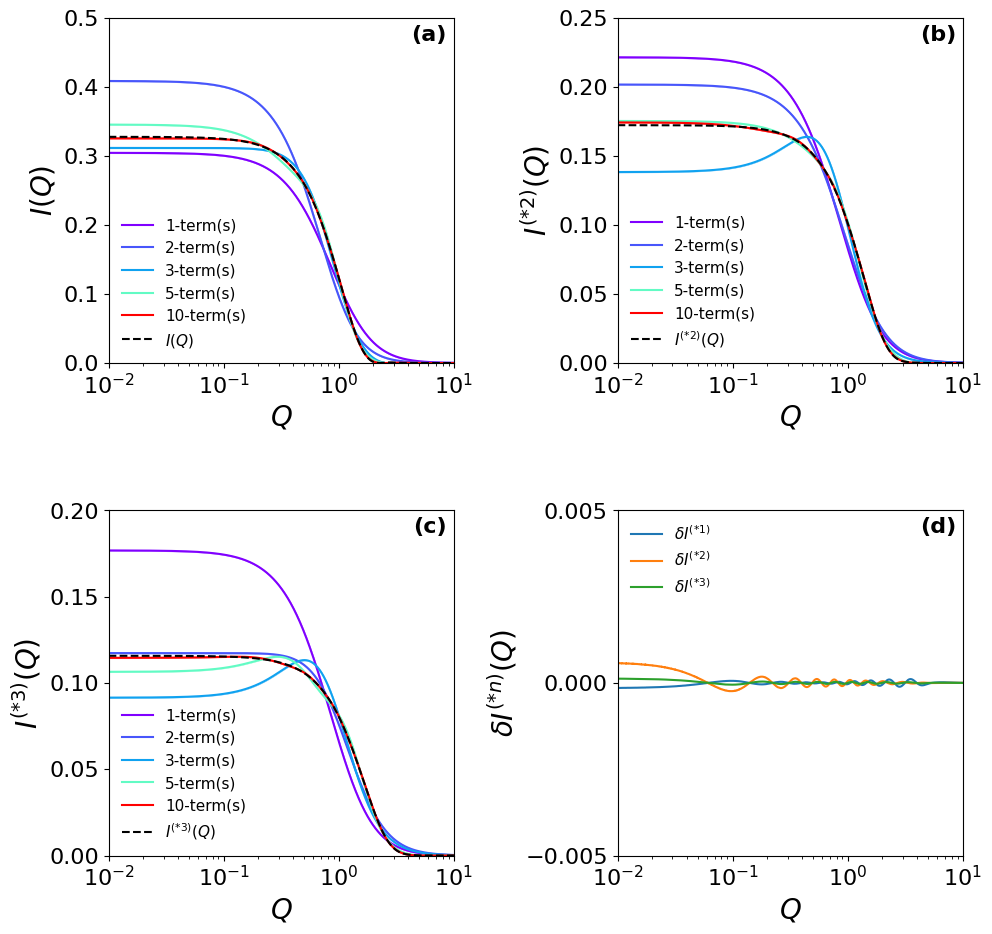

In [31]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Left panel: Basis expansion of I(Q)
ax = axs[0,0]
plotting_n_max = 10
plotting_n_list = [1, 2, 3, 5, 10]
colors = plt.cm.rainbow(np.linspace(0, 1, plotting_n_max))
for i, (ci, ei) in enumerate(zip(coeffs, errs), start=1):
    if i not in plotting_n_list:
        continue
    fQ_rec, fQ_err = reconstruct_from_coeffs(Q_grid, coeffs[:i], a, b=b, errs=errs[:i])
    ax.plot(Q_grid, fQ_rec, '-', label=f'{i}-term(s)', color=colors[i-1])
    ax.fill_between(Q_grid, fQ_rec - fQ_err, fQ_rec + fQ_err, alpha=0.3, color=colors[i-1])
ax.plot(Q_grid, fQ_grid, '--', label=r'$I(Q)$', color='black')
ax.set_xscale('log')
ax.set_xlabel(r'$Q$', fontsize=20)
ax.set_ylabel(r'$I(Q)$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=11, frameon=False)
ax.set_xlim(1e-2, 1e1)
ax.set_ylim(0, 0.5)
ax.set_aspect((3) / (ax.get_ylim()[1] - ax.get_ylim()[0]))
ax.text(0.98, 0.98, '(a)', transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# Right panel: Basis expansion of I^{*2}(Q)
ax = axs[0,1]
for i, (ci, ei) in enumerate(zip(coeffs_2, errs), start=1):
    if i not in plotting_n_list:
        continue
    fQ_rec, fQ_err = reconstruct_from_coeffs(Q_grid, coeffs_2[:i], a, b=b, errs=errs[:i])
    ax.plot(Q_grid, fQ_rec, '-', label=f'{i}-term(s)', color=colors[i-1])
    ax.fill_between(Q_grid, fQ_rec - fQ_err, fQ_rec + fQ_err, alpha=0.3, color=colors[i-1])
ax.plot(Q_grid, f2Q_grid, '--', label=r'$I^{(*2)}(Q)$', color='black')
ax.set_xscale('log')
ax.set_xlabel(r'$Q$', fontsize=20)
ax.set_ylabel(r'$I^{(*2)}(Q)$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=11, frameon=False)
ax.set_xlim(1e-2, 1e1)
ax.set_ylim(0, 0.25)
ax.set_aspect((3) / (ax.get_ylim()[1] - ax.get_ylim()[0]))
ax.text(0.98, 0.98, '(b)', transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# Left panel: Basis expansion of I^{*3}(Q)
ax = axs[1,0]
for i, (ci, ei) in enumerate(zip(coeffs_3, errs), start=1):
    if i not in plotting_n_list:
        continue
    fQ_rec, fQ_err = reconstruct_from_coeffs(Q_grid, coeffs_3[:i], a, b=b, errs=errs[:i])
    ax.plot(Q_grid, fQ_rec, '-', label=f'{i}-term(s)', color=colors[i-1])
    ax.fill_between(Q_grid, fQ_rec - fQ_err, fQ_rec + fQ_err, alpha=0.3, color=colors[i-1])
ax.plot(Q_grid, f3Q_grid, '--', label=r'$I^{(*3)}(Q)$', color='black')
ax.set_xscale('log')
ax.set_xlabel(r'$Q$', fontsize=20)
ax.set_ylabel(r'$I^{(*3)}(Q)$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=11, frameon=False)
ax.set_xlim(1e-2, 1e1)
ax.set_ylim(0, 0.20)
ax.set_aspect((3) / (ax.get_ylim()[1] - ax.get_ylim()[0]))
ax.text(0.98, 0.98, '(c)', transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# Right panel: deviations
ax = axs[1,1]
for i_n, (coeffs_i, errs_i) in enumerate(zip([coeffs, coeffs_2, coeffs_3], [errs, errs_2, errs_3])):
    for i, (ci, ei) in enumerate(zip(coeffs_i, errs_i), start=1):
        if i not in [10]:
            continue
        fQ_rec, fQ_err = reconstruct_from_coeffs(Q_grid, coeffs_i, a, b=b, errs=errs_i)
        ax.plot(Q_grid, fQ_rec - fQ_grid if coeffs_i is coeffs else fQ_rec - f2Q_grid if coeffs_i is coeffs_2 else fQ_rec - f3Q_grid,
                '-', label=fr'$\delta I^{{(*{i_n+1})}}$')
        # ax.fill_between(Q_grid,
        #                 (fQ_rec - fQ_grid if coeffs_i is coeffs else fQ_rec - f2Q_grid if coeffs_i is coeffs_2 else fQ_rec - f3Q_grid) - fQ_err,
        #                 (fQ_rec - fQ_grid if coeffs_i is coeffs else fQ_rec - f2Q_grid if coeffs_i is coeffs_2 else fQ_rec - f3Q_grid) + fQ_err,
        #                 alpha=0.3)

ax.set_xscale('log')
ax.set_xlabel(r'$Q$', fontsize=20)
ax.set_ylabel(r'$\delta I^{(*n)}(Q)$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=11, frameon=False)
ax.set_xlim(1e-2, 1e1)
ax.set_yticks(np.linspace(-5e-3, 5e-3, 3))
ax.set_aspect((3) / (ax.get_ylim()[1] - ax.get_ylim()[0]))
ax.text(0.98, 0.98, '(d)', transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

plt.tight_layout()
plt.show()

## test structure constant method

In [32]:
# ============================================================
# Structure constants
#   C_{nm}^ell = (2π)^2 ∫_0^∞ k * u~_ell(k) u~_n(k) u~_m(k) dk
#
# In dimensionless variable B=k/a, with your dimensionless u_tilde_n_B(B),
# the natural “dimensionless” version is
#   Cbar_{nm}^ell = (2π)^2 ∫_0^∞ B * u~_ell(B) u~_n(B) u~_m(B) dB
#
# If you want the *physical* C_{nm}^ell in k-units, add a scaling factor
# depending on your Hankel convention; see comment in code below.
# ============================================================

import numpy as np

def f_Cjkl(
    n_max: int,
    a: float,
    b: float,
    *,
    B_min: float = 1e-6,
    B_max: float = 1e3,
    NB: int = 4000,
    u_tilde_n_B=None,
    dtype=np.float64,
):
    """
    Construct structure coefficients C_{jk}^ell for isotropic 2D convolution.

    Computes:
        C_{jk}^ell = (2π)^2 / a * ∫_0^∞ B dB
                     ũ̄_ell(B) ũ̄_j(B) ũ̄_k(B)

    Parameters
    ----------
    n_max : int
        Maximum basis index.
    a : float
        Basis length scale.
    b : float
        Basis shape parameter.
    B_min, B_max : float
        Dimensionless Hankel variable range.
    NB : int
        Number of B-grid points.
    u_tilde_n_B : callable
        u_tilde_n_B(n, B, b=...) → array of shape B.shape
        Must return the *dimensionless* Hankel transform ũ̄_n(B).

    Returns
    -------
    Cjkl : callable
        Cjkl(j, k, ell) → float
    meta : dict
        Cached grids and transforms.
    """
    if u_tilde_n_B is None:
        raise ValueError("u_tilde_n_B must be provided")

    n_max = int(n_max)
    if n_max < 1:
        raise ValueError("n_max must be >= 1")
    a = float(a)
    if a <= 0:
        raise ValueError("a must be > 0")

    # ---- B grid (log-spaced, positive) ----
    B = np.logspace(np.log10(B_min), np.log10(B_max), NB).astype(dtype)

    # trapezoid weights
    wB = np.zeros_like(B)
    wB[1:-1] = 0.5 * (B[2:] - B[:-2])
    wB[0]    = 0.5 * (B[1] - B[0])
    wB[-1]   = 0.5 * (B[-1] - B[-2])

    # measure B dB
    W = B * wB

    # ---- precompute ũ̄_n(B) ----
    U = np.zeros((n_max, NB), dtype=dtype)
    for n in range(1, n_max + 1):
        U[n - 1] = np.asarray(u_tilde_n_B(n, B, b=b), dtype=dtype)

    # physical prefactor
    pref = (2.0 * np.pi) ** 2 / a

    # cache for symmetry + reuse
    cache = {}

    def Cjkl(j: int, k: int, ell: int) -> float:
        j = int(j); k = int(k); ell = int(ell)
        if not (1 <= j <= n_max and 1 <= k <= n_max and 1 <= ell <= n_max):
            raise ValueError("indices must be in 1..n_max")

        # symmetry in (j,k)
        if k > j:
            j, k = k, j

        key = (ell, j, k)
        if key in cache:
            return cache[key]

        val = pref * np.dot(
            W,
            U[ell - 1] * U[j - 1] * U[k - 1]
        )

        cache[key] = float(val)
        return float(val)

    meta = dict(
        a=a,
        b=b,
        B=B,
        wB=wB,
        W=W,
        U=U,
        prefactor=pref,
        B_min=B_min,
        B_max=B_max,
        NB=NB,
    )

    return Cjkl, meta

def build_C_tensor(
    L: int,
    *,
    Cjkl=None,              # NEW: function Cjkl(j,k,ell) -> float
    C_nmk=None,             # legacy: function C_nmk(n,m,ell, ...) -> (val, err)
    dtype=np.float64,
    sym_jk: bool = True,    # use C_{jk}^ell = C_{kj}^ell
    # legacy quadrature args (only used if C_nmk is provided)
    quad: str = "laguerre",
    N: int = 160,
    Bmax: float = 80.0,
    epsabs: float = 1e-10,
    epsrel: float = 1e-9,
):
    """
    Build C[ell-1, j-1, k-1] = C_{jk}^{ell} for j,k,ell in {1..L}.

    You can supply either:
      - Cjkl(j,k,ell) -> float   (preferred; grid-precomputed, fast)
      - C_nmk(n,m,ell, quad=..., N=..., Bmax=..., epsabs=..., epsrel=...) -> (val, err)  (legacy)

    Returns
    -------
    C : ndarray, shape (L, L, L)
        C[ell, j, k] with 0-based indexing.
    """
    L = int(L)
    if L < 1:
        raise ValueError("L must be >= 1.")

    if (Cjkl is None) == (C_nmk is None):
        raise ValueError("Provide exactly one of Cjkl or C_nmk.")

    C = np.zeros((L, L, L), dtype=dtype)

    # -------- preferred path: Cjkl(j,k,ell)->float --------
    if Cjkl is not None:
        for ell in range(1, L + 1):
            for j in range(1, L + 1):
                k_range = range(1, j + 1) if sym_jk else range(1, L + 1)
                for k in k_range:
                    val = float(Cjkl(j, k, ell))
                    C[ell - 1, j - 1, k - 1] = val
                    if sym_jk and k != j:
                        C[ell - 1, k - 1, j - 1] = val
        return C

    # -------- legacy path: C_nmk(...) -> (val, err) --------
    for ell in range(1, L + 1):
        for j in range(1, L + 1):
            k_range = range(1, j + 1) if sym_jk else range(1, L + 1)
            for k in k_range:
                val, _ = C_nmk(
                    j, k, ell,
                    quad=quad, N=N, Bmax=Bmax,
                    epsabs=epsabs, epsrel=epsrel
                )
                val = float(val)
                C[ell - 1, j - 1, k - 1] = val
                if sym_jk and k != j:
                    C[ell - 1, k - 1, j - 1] = val

    return C


def convolve_coeffs(C: np.ndarray, f: np.ndarray, g: np.ndarray) -> np.ndarray:
    """
    h_ell = sum_{j,k} C_{jk}^{ell} f_j g_k

    Inputs
    ------
    C : (L, L, L) with C[ell,j,k] = C_{jk}^{ell}
    f, g : (L,)

    Returns
    -------
    h : (L,)
    """
    C = np.asarray(C, float)
    f = np.asarray(f, float)
    g = np.asarray(g, float)

    if C.ndim != 3 or C.shape[1] != f.size or C.shape[2] != g.size:
        raise ValueError("Shape mismatch: C must be (L,L,L), f and g must be (L,).")

    # (ell,j,k) · (j) · (k) -> (ell)
    return np.einsum("ejk,j,k->e", C, f, g, optimize=True)


def self_convolve_coeffs(C: np.ndarray, a: np.ndarray) -> np.ndarray:
    """
    a2_ell = sum_{j,k} C_{jk}^{ell} a_j a_k
    """
    return convolve_coeffs(C, a, a)

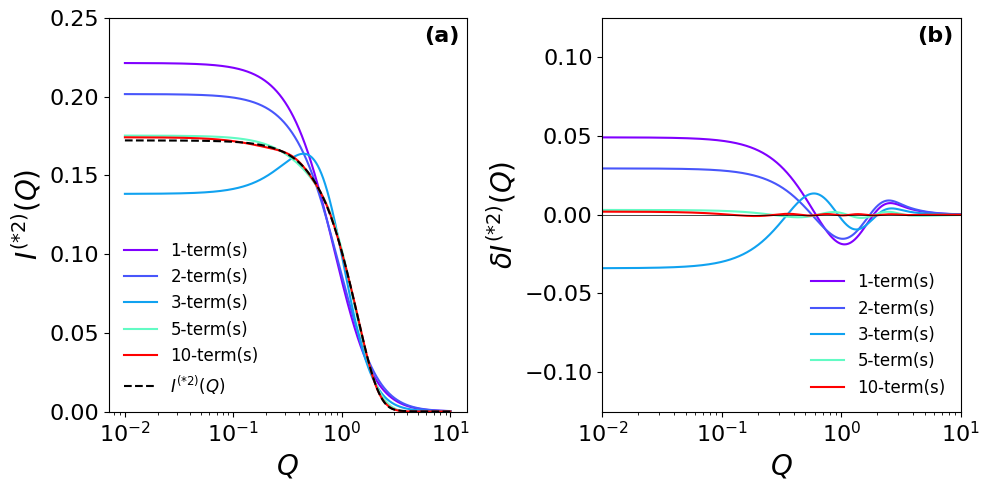

In [33]:
## test extract coefficients for convolved function using structure constants
Cjkl, metaC = f_Cjkl(n_max=n_max, a=a, b=b, NB=6000, B_min=1e-6, B_max=1e3, u_tilde_n_B=u_tilde_n_B)
C = build_C_tensor(n_max, Cjkl=Cjkl, sym_jk=True)
coeffs_2_C = self_convolve_coeffs(C, coeffs)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Left panel: Current figure
ax = axs[0]
plotting_n_max = 10
plotting_n_list = [1, 2, 3, 5, 10]
colors = plt.cm.rainbow(np.linspace(0, 1, plotting_n_max))
for i, (ci, ei) in enumerate(zip(coeffs_2_C, errs), start=1):
    if i not in plotting_n_list:
        continue
    fQ_rec, fQ_err = reconstruct_from_coeffs(Q_grid, coeffs_2_C[:i], a, b=b, errs=errs[:i])
    ax.plot(Q_grid, fQ_rec, '-', label=f'{i}-term(s)', color=colors[i-1])
ax.plot(Q_grid, f2Q_grid, '--', label=r'$I^{(*2)}(Q)$', color='black')
ax.set_xscale('log')
ax.set_xlabel(r'$Q$', fontsize=20)
ax.set_ylabel(r'$I^{(*2)}(Q)$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=12, frameon=False)
ax.set_ylim(0, 0.25)
ax.text(0.98, 0.98, '(a)', transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')


# Right panel: Difference from f2Q_grid
ax = axs[1]
for i, (ci, ei) in enumerate(zip(coeffs_2_C, errs), start=1):
    if i not in plotting_n_list:
        continue
    fQ_rec, fQ_err = reconstruct_from_coeffs(Q_grid, coeffs_2_C[:i], a, b=b, errs=errs[:i])
    ax.plot(Q_grid, fQ_rec - f2Q_grid, '-', label=f'{i}-term(s)', color=colors[i-1])
    fQ_rec, fQ_err = reconstruct_from_coeffs(Q_grid, coeffs_2[:i], a, b=b, errs=errs[:i])
    # ax.plot(Q_grid, fQ_rec - f2Q_grid, ':', color=colors[i-1])
ax.axhline(0, color='black', linestyle='-', linewidth=0.5)
ax.set_xscale('log')
ax.set_xlabel(r'$Q$', fontsize=20)
ax.set_ylabel(r'$\delta I^{(*2)}(Q)$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=12, frameon=False)
ax.set_ylim(-0.125, 0.125)
ax.set_xlim(1e-2, 1e1)
ax.text(0.98, 0.98, '(b)', transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

plt.tight_layout()
plt.show()

/tmp/ipykernel_2507886/2505291317.py:59: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=12, frameon=False)


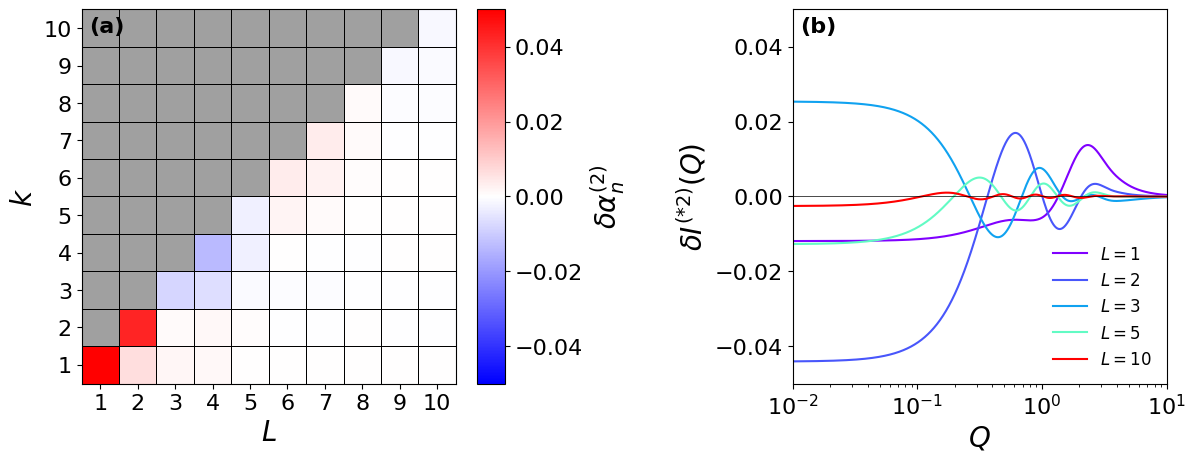

In [34]:
## test extract coefficients for convolved function using structure constants
Cjkl, metaC = f_Cjkl(n_max=n_max, a=a, b=b, NB=6000, B_min=1e-6, B_max=1e3, u_tilde_n_B=u_tilde_n_B)
C = build_C_tensor(n_max, Cjkl=Cjkl, sym_jk=True)
coeffs_2_C = self_convolve_coeffs(C, coeffs)

coeffs_2_C_list = []
errs_2_C_list = []
for i in range(1, n_max + 1):
    coeffs_2_C_i = self_convolve_coeffs(C[:i, :i, :i], coeffs[:i])
    coeffs_2_C_list.append(coeffs_2_C_i)
    errs_2_C_i = coeffs_2_C_i*1e-4
    errs_2_C_list.append(errs_2_C_i)
    
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Left panel: Current figure
ax = axs[0]
# plotting_n_max = 10
# plotting_n_list = [1, 2, 3, 5, 10]
# colors = plt.cm.rainbow(np.linspace(0, 1, plotting_n_max))
# for i, (ci, ei) in enumerate(zip(coeffs_2_C_list, errs_2_C_list), start=1):
#     if i not in plotting_n_list:
#         continue
#     fQ_rec, fQ_err = reconstruct_from_coeffs(Q_grid, coeffs_2_C_list[i], a, b=b, errs=errs_2_C_list[i])
#     ax.plot(Q_grid, fQ_rec, '-', label=f'{i}-term(s)', color=colors[i-1])
# ax.plot(Q_grid, f2Q_grid, '--', label=r'$I^{(*2)}(Q)$', color='black')
# ax.set_xscale('log')
# ax.set_xlabel(r'$Q$', fontsize=20)
# ax.set_ylabel(r'$I^{(*2)}(Q)$', fontsize=20)
# ax.tick_params(axis='both', which='major', labelsize=16)
# ax.legend(fontsize=12, frameon=False)
# ax.set_ylim(0, 0.25)
# ax.text(0.98, 0.98, '(a)', transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

grid = np.full((10, 10), np.nan)

for i, (ci, ei) in enumerate(zip(coeffs_2_C_list[:10], errs_2_C_list[:10]), start=1):
    coeffs_2_C_ref = coeffs_2_C[:i]
    grid[i-1, :i] = coeffs_2_C_list[i-1][:i] - coeffs_2_C_ref
cmap = plt.cm.bwr.copy()
cmap.set_bad(color='#A0A0A0')   # NaNs → grey

pcm = ax.pcolormesh(
    np.arange(1, 11),
    np.arange(1, 11),
    grid.T,
    cmap=cmap,
    shading='auto',
    vmin=-5e-2, vmax=5e-2,
    edgecolors='k', linewidth=0.5  # Add pixel borders
)
# plt.colorbar(pcm, ax=ax)

ax.set_xlabel(r'$L$', fontsize=20)
ax.set_ylabel(r'$k$', fontsize=20)
ax.set_xticks(np.arange(1, 11))
ax.set_yticks(np.arange(1, 11))
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=12, frameon=False)
ax.set_aspect(1)
ax.text(0.02, 0.98, '(a)', transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='left')


# Right panel: Difference from f2Q_grid
ax = axs[1]
for i, (ci, ei) in enumerate(zip(coeffs_2_C_list, errs_2_C_list), start=1):
    if i not in plotting_n_list:
        continue
    fQ_rec, fQ_err = reconstruct_from_coeffs(Q_grid, coeffs_2_C_list[i], a, b=b, errs=errs_2_C_list[i])
    ax.plot(Q_grid, fQ_rec - f2Q_grid, '-', label=f'$L = {i}$', color=colors[i-1])
ax.axhline(0, color='black', linestyle='-', linewidth=0.5)
ax.set_xscale('log')
ax.set_xlabel(r'$Q$', fontsize=20)
ax.set_ylabel(r'$\delta I^{(*2)}(Q)$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=12, frameon=False)
ax.set_ylim(-0.05, 0.05)
ax.set_xlim(1e-2, 1e1)
ax.set_aspect((3) / (ax.get_ylim()[1] - ax.get_ylim()[0]))
ax.text(0.02, 0.98, '(b)', transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='left')

plt.subplots_adjust(wspace=0.9)

bbox = axs[0].get_position()
cax = fig.add_axes([
    bbox.x1 + 0.015,   # x position to the right of ax0
    bbox.y0,           # align bottom
    0.02,              # width
    bbox.height        # match height
])

cbar = fig.colorbar(pcm, cax=cax)
cbar.set_label(r'$\delta \alpha_n^{(2)}$', fontsize=20)
cbar.ax.tick_params(labelsize=16)

# plt.tight_layout(pad = 2)
plt.show()

# multiple scattering

In [35]:
def multiple_scattering_series(
    IQ,                 # callable: unnormalized \hat I(Q)
    T: float,
    *,
    a: float = 1.0,
    N_max: int = 5,
    Q_min: float = 1e-2,
    Q_max: float = 1e2,
    NQ: int = 2000,
    NB: int = 2000,
    chunk_B: int = 64,
    chunk_A: int = 4096,
    norm_eps: float = 1e-300,
):
    """
    Returns a callable I_Q(Q) implementing

        I^{App}(Q)
        = sum_{n=1}^{N_max} P_n * I^{(*n)}(Q) / I0^{n-1}

    plus metadata including I0 and the delta(Q) weight P0*I0.
    """

    T = float(T)
    if T < 0:
        raise ValueError("T must be >= 0.")
    print(f"T = {T:.6e}")

    # -------------------------------------------------
    # Compute I0 = ∫ 2π Q f(Q) dQ   (positive Q only)
    # -------------------------------------------------
    Q_pos = np.logspace(np.log10(Q_min), np.log10(Q_max), int(NQ))
    f_pos = np.array([float(IQ(float(q))) for q in Q_pos])

    _, I0 = compute_normalization(
        f=f_pos,
        Q=Q_pos,
        kind="integral",
        domain="Q",
        measure="radial",
        include_2pi=True,
        eps=norm_eps,
    )
    I0 = float(I0)

    # -------------------------------------------------
    # Poisson weights
    # -------------------------------------------------
    mu = -np.log(T)
    P = np.zeros(N_max + 1)
    P[0] = np.exp(-mu)
    for n in range(1, N_max + 1):
        P[n] = P[n - 1] * (mu / n)

    delta_weight = P[0] * I0

    # -------------------------------------------------
    # Build n-fold convolution callables
    # -------------------------------------------------    
    fQ = lambda Q: IQ(Q)/ I0     
    conv_funcs = [fQ]
    for n in range(2, N_max + 1):
        fnQ, _ = build_f_nconv(
        fQ,
        n_conv=n,
        a=a,
        Q_min=Q_min,
        Q_max=Q_max,
        NQ=NQ,
        NB=NB,
        chunk_A=chunk_A,
        chunk_B=chunk_B,
        normalize_input=False,
        normalize_output=False,
        norm_kind="integral",
        norm_domain="Q",
        norm_measure="radial",
        )
        Q_grid = np.logspace(np.log10(Q_min), np.log10(Q_max), int(NQ))
        scale_n, _ = compute_normalization(fnQ(Q_grid), Q_grid,
                                  kind="integral", domain="Q", measure="radial", include_2pi=True)
        # print(f"scale = {scale_n:.6e}, original integral = {I0_n:.6e} (∫ 2π Q f(Q) dQ)")
        fnQ_scaled = lambda Q, fnQ=fnQ, scale_n=scale_n: scale_n * fnQ(Q)
        conv_funcs.append(fnQ_scaled)

    # -------------------------------------------------
    # Final callable: THIS is what you care about
    # -------------------------------------------------
    # multiple sattered, normalized probability density
    def fQ_ms(Q):
        """
        Apparent multiple-scattering intensity (no delta term).
        Accepts scalar or array Q >= 0.
        """
        Q_arr = np.asarray(Q, float)
        if np.any(Q_arr < 0):
            raise ValueError("Q must be >= 0.")

        acc = np.zeros_like(Q_arr, dtype=float)
        for n in range(1, N_max + 1):
            acc += P[n] * conv_funcs[n - 1](Q_arr)

        return float(acc) if acc.shape == () else acc

    # Optional helper if you explicitly want a discrete spike at Q=0
    def fQ_ms_with_delta(Q):
        Q_arr = np.asarray(Q, float)
        y = fQ_ms(Q_arr)
        if np.asarray(y).shape == ():
            return float(y + (delta_weight if Q_arr == 0.0 else 0.0))
        y = np.asarray(y)
        return np.where(Q_arr == 0.0, y + delta_weight, y)

    return {
        "fQ_ms": fQ_ms,                         # <-- callable
        "fQ_ms_with_delta": fQ_ms_with_delta,   # <-- callable
        "I0": I0,
        "P": P,
        "delta_weight": delta_weight,
        "conv_funcs": conv_funcs,
    }


In [43]:
## prepare scattering function and normalization
Rg = 1
# scattering function
# not yet normalized by probability measure, i.e. plain f(Q)
# def fQ_raw(Q): 
#     return debye_scattering(Q, Rg)

def fQ_raw(Q):
    return fuzzy_ball(Q, R=Rg*2, s=Rg/2)

# grid for plotting / normalization
Q_grid = np.logspace(-2, 1, 2500)
fQ_raw_grid = fQ_raw(Q_grid)

# choose normalization convention
norm_kind   = "integral"
norm_domain = "Q"
norm_measure= "radial"

# build normalized probability density 
scale, I0 = compute_normalization(fQ_raw_grid, Q_grid,
                                  kind=norm_kind, domain=norm_domain, measure=norm_measure, include_2pi=True)
print(f"scale = {scale:.6e}, original integral = {I0:.6e} (∫ 2π Q f(Q) dQ)")

def fQ(Q):
    return scale * fQ_raw(Q)
fQ_grid = fQ(Q_grid)

scale_fQ, I0 = compute_normalization(fQ_grid, Q_grid, 
                                     kind=norm_kind, domain=norm_domain, measure=norm_measure, include_2pi=True)
print(f"fQ normalization factor = {scale_fQ:.6e}, fQ integral = {I0:.6e}")

scale = 3.276123e-01, original integral = 3.052388e+00 (∫ 2π Q f(Q) dQ)
fQ normalization factor = 1.000000e+00, fQ integral = 1.000000e+00


T = 2.500000e-01


/tmp/ipykernel_2507886/2864527862.py:28: RuntimeWarning: invalid value encountered in scalar divide
  return 9 * (np.sin(QR) - QR * np.cos(QR))**2 / (QR)**6 * np.exp(-Qs ** 2 / 2)


n	P_n
0	2.500e-01
1	3.466e-01
2	2.402e-01
3	1.110e-01
4	3.847e-02
5	1.067e-02
6	2.465e-03
7	4.881e-04
8	8.458e-05
9	1.303e-05
10	1.806e-06


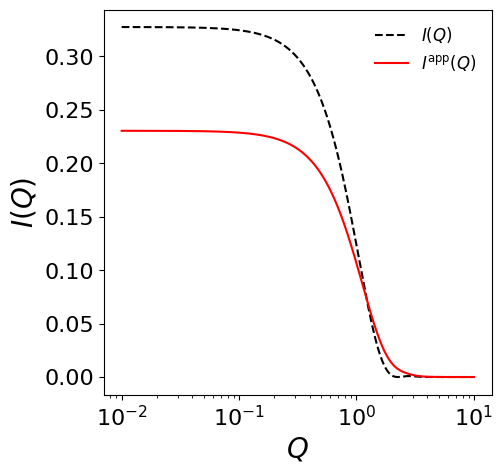

In [68]:
T = 0.25 # transmission
N_max = 10 # number of terms in multiple scattering series

ms = multiple_scattering_series(
        fQ_raw, T=T, a=a, N_max=N_max,
        Q_min=1e-2,
        Q_max=1e2,
        NQ=2000,
        NB=2000,
        )

# print probability weights of n-fold scattering
print("n\tP_n")
for n, Pn in enumerate(ms["P"]):
    print(f"{n}\t{Pn:.3e}")     
    
# plot apparent I(Q) with multiple scattering
Q_grid = np.logspace(-2, 1, 2500)
fQ_ms = ms["fQ_ms"]
fQ_ms_grid = fQ_ms(Q_grid)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(Q_grid, fQ_grid, '--', label=r'$I(Q)$', color='black')
ax.plot(Q_grid, fQ_ms_grid/(1-T), '-', label=r'$I^{\mathrm{app}}(Q)$', color='red')

# for n in range(1, N_max + 1):
#     fnQ_grid = ms["conv_funcs"][n - 1](Q_grid)
#     ax.plot(Q_grid, fnQ_grid, ':', label=f'$I^{{(*{n})}}(Q)$', color='gray')

ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel(r'$Q$', fontsize=20)
ax.set_ylabel(r'$I(Q)$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=12, frameon=False)
# ax.set_ylim(0, 2)

In [115]:

def poisson_weights(mu: float, n_max: int) -> np.ndarray:
    """
    P_n = exp(-mu) mu^n / n!, for n=0..n_max
    """
    P = np.empty(n_max + 1, dtype=float)
    P[0] = np.exp(-mu)
    for n in range(1, n_max + 1):
        P[n] = P[n-1] * mu / n  # stable recursion
    return P


def contract_C(C: np.ndarray, x: np.ndarray, y: np.ndarray) -> np.ndarray:
    """
    (x * y)_ell = sum_{j,k} C[j,k,ell] x_j y_k
    C shape: (L, L, L) with indices (j,k,ell).
    x,y shape: (L,)
    returns shape: (L,)
    """
    # einsum is clear and fast enough for moderate L
    return np.einsum("jkl,j,k->l", C, x, y, optimize=True)


def beta_from_alpha1(
    alpha1: np.ndarray,
    mu: float,
    *,
    a: float,
    b: float,
    n_max: int = 10,
    C: np.ndarray | None = None,
    # If you want this function to build C internally, pass the builders below.
    # They should match your existing codebase signatures.
    f_Cjkl=None,
    build_C_tensor=None,
    C_build_kwargs: dict | None = None,
):
    """
    Given single-scattering expansion coefficients alpha^(1) (for J(Q)=I_hat/I0),
    and Poisson mean mu = -ln T, compute the multiply scattered *coefficient* result:

        beta_ell = sum_{n=1..n_max} P_n alpha_ell^(n)

    with recursion:
        alpha^(n) = C[ alpha^(1), alpha^(n-1) ]  (tensor contraction)

    Parameters
    ----------
    alpha1 : (L,) array
        Coefficients alpha^(1) in your basis u_ell(Q), ell=1..L.
    mu : float
        Mean event count, mu=-ln T.
    a, b : float
        Basis parameters (passed through in case you build C internally).
    n_max : int
        Truncation order for multiple scattering.
    C : (L,L,L) array, optional
        Precomputed structure-constant tensor C[j,k,ell].
        If None, the function will try to build it using (f_Cjkl, build_C_tensor).
    f_Cjkl, build_C_tensor : callables, optional
        Your existing builders to compute C from (a,b,...).
    C_build_kwargs : dict, optional
        Extra args forwarded to f_Cjkl/build_C_tensor.

    Returns
    -------
    out : dict with keys
        - "mu", "P": Poisson weights P[0..n_max]
        - "alpha_n": list of arrays [alpha^(1), ..., alpha^(n_max)]
        - "beta": array (L,), beta_ell
        - "P0": float, P_0 (delta term weight)
        - "C": the tensor used
    """
    alpha1 = np.asarray(alpha1, dtype=float)
    L = alpha1.size

    # Build C if not provided
    if C is None:
        if f_Cjkl is None or build_C_tensor is None:
            raise ValueError(
                "C is None. Provide a precomputed C tensor, OR pass f_Cjkl and build_C_tensor."
            )
        kw = {} if C_build_kwargs is None else dict(C_build_kwargs)

        # --- You may need to adjust these kwargs to match your own builder signatures. ---
        # Typical pattern from your snippets:
        #   Cjkl, metaC = f_Cjkl(n_max=L, a=a, b=b, NB=..., B_min=..., B_max=..., u_tilde_n_B=...)
        #   C = build_C_tensor(L, Cjkl=Cjkl, sym_jk=True)
        Cjkl, metaC = f_Cjkl(n_max=L, a=a, b=b, **kw)
        C = build_C_tensor(L, Cjkl=Cjkl, sym_jk=True)

    C = np.asarray(C, dtype=float)
    if C.shape[0] != L or C.shape[1] != L or C.shape[2] != L:
        raise ValueError(f"C must have shape (L,L,L) with L={L}. Got {C.shape}.")

    # Poisson weights
    P = poisson_weights(mu, n_max)
    P0 = P[0]

    # Compute alpha^(n)
    alpha_n = [None] * (n_max + 1)  # index by n
    alpha_n[1] = alpha1.copy()
    for n in range(2, n_max + 1):
        alpha_n[n] = contract_C(C, alpha1, alpha_n[n - 1])

    # beta coefficients (exclude n=0 by definition)
    beta = np.zeros(L, dtype=float)
    for n in range(1, n_max + 1):
        beta += P[n] * alpha_n[n]

    return {
        "mu": mu,
        "P": P,
        "P0": P0,
        "alpha_n": alpha_n[1:],  # [alpha^(1),...,alpha^(n_max)]
        "beta": beta,
        "C": C,
        "a": a,
        "b": b,
        "n_max": n_max,
    }


import numpy as np

def Iapp_from_beta(
    Q_grid,
    beta,
    *,
    a: float,
    b: float = 1.0,
    I0: float = 1.0,
    errs_beta=None,
    P0: float | None = None,
    include_delta: bool = False,
    reconstruct_from_coeffs=None,
):
    """
    Construct the apparent scattered intensity from beta coefficients using your
    existing basis reconstruction routine:

        I^App(Q) = I0 [ sum_ell beta_ell u_ell(Q) + P0 delta(Q) ].

    Notes
    -----
    - This function returns ONLY the scattered component (the smooth part)
      as an array on Q_grid:
          I_scatt(Q) = I0 * sum_ell beta_ell u_ell(Q)
    - The delta(Q) term cannot be represented as a regular function on a grid.
      If include_delta=True, we return metadata containing P0 and a note.
      (You can handle the delta spike via your instrument/binning model.)

    Parameters
    ----------
    Q_grid : array-like
    beta : array-like, shape (L,)
        Apparent expansion coefficients beta_ell.
    a, b : float
        Basis parameters passed to reconstruct_from_coeffs.
    I0 : float
        Overall intensity scale in Eq. (expansion_app).
    errs_beta : array-like or None
        Standard deviations for beta_ell (propagated pointwise if provided).
    P0 : float or None
        Weight of the delta term (typically P0 = exp(-mu)).
    include_delta : bool
        If True, return (I_scatt, meta) where meta includes P0 and a note.
    reconstruct_from_coeffs : callable
        Your function reconstruct_from_coeffs(Q_grid, coeffs, a, errs=None, b=1.0).

    Returns
    -------
    I_scatt : ndarray
        Scattered component on Q_grid.
    I_scatt_err : ndarray (optional)
        If errs_beta is provided.
    meta : dict (optional)
        Only if include_delta=True.
    """
    if reconstruct_from_coeffs is None:
        raise ValueError("Please pass reconstruct_from_coeffs=your_function.")

    beta = np.asarray(beta, float)

    if errs_beta is None:
        I_scatt = I0 * reconstruct_from_coeffs(Q_grid, beta, a, b=b)
        if include_delta:
            meta = {
                "P0": P0,
                "delta_note": "delta(Q) is a distribution; handle separately (beamstop/binning model).",
            }
            return I_scatt, meta
        return I_scatt

    errs_beta = np.asarray(errs_beta, float)
    I_scatt, I_scatt_err = reconstruct_from_coeffs(Q_grid, beta, a, errs=errs_beta, b=b)
    I_scatt *= I0
    I_scatt_err *= I0

    if include_delta:
        meta = {
            "P0": P0,
            "delta_note": "delta(Q) is a distribution; handle separately (beamstop/binning model).",
        }
        return I_scatt, I_scatt_err, meta

    return I_scatt, I_scatt_err

def f_alpha1_Iapp(coeff, Q):
    """
    Given a single coefficient vector alpha^(1), reconstruct the apparent I(Q).
    This is essentially a wrapper around beta_from_alpha1 and Iapp_from_beta
    for the special case of a single-scattering input.

    Parameters
    ----------
    coeff : array-like, shape (L,)
        Coefficients alpha^(1) in your basis.
    Q : array-like
        Q values to evaluate I^App(Q).

    Returns
    -------
    I_app : array, shape Q.shape
        Apparent intensity on the given Q grid.
    """
    ms = beta_from_alpha1(
        alpha1=coeff,
        mu=-np.log(T),
        a=a, b=b,
        n_max=10,
        f_Cjkl=f_Cjkl,
        build_C_tensor=build_C_tensor,
        C_build_kwargs=dict(NB=6000, B_min=1e-6, B_max=1e3, u_tilde_n_B=u_tilde_n_B),
    )
    beta = ms["beta"]
    P0 = ms["P0"]

    I_app = Iapp_from_beta(Q, beta, a=a, b=b, I0=I0, P0=P0, include_delta=False, reconstruct_from_coeffs=reconstruct_from_coeffs)
    return I_app

from scipy.optimize import least_squares

def fit_alpha1_to_Iobs(
    alpha1_init,
    Q_obs,
    I_obs,
    *,
    delta_I_obs=None,   # <-- uncertainties
    T,
    a,
    b,
    I0,
    n_max=10,
    f_Cjkl=None,
    build_C_tensor=None,
    u_tilde_n_B=None,
    C_build_kwargs=None,
    reconstruct_from_coeffs=None,
    bounds=(-np.inf, np.inf),
    loss="linear",
    f_scale=1.0,
    verbose=2,
):
    """
    Weighted fit if delta_I_obs is provided:
        r_i = (I_app - I_obs)/delta_I_obs
    """

    if reconstruct_from_coeffs is None:
        raise ValueError("Provide reconstruct_from_coeffs.")
    if f_Cjkl is None or build_C_tensor is None:
        raise ValueError("Provide f_Cjkl and build_C_tensor.")

    Q_obs = np.asarray(Q_obs, float)
    I_obs = np.asarray(I_obs, float)
    if Q_obs.shape != I_obs.shape:
        raise ValueError("Q_obs and I_obs must have the same shape.")

    mu = -np.log(T)

    # Build C once
    kw = {} if C_build_kwargs is None else dict(C_build_kwargs)
    if u_tilde_n_B is not None:
        kw.setdefault("u_tilde_n_B", u_tilde_n_B)

    L = np.asarray(alpha1_init, float).size
    Cjkl, metaC = f_Cjkl(n_max=L, a=a, b=b, **kw)
    C = build_C_tensor(L, Cjkl=Cjkl, sym_jk=True)

    # weights from uncertainties
    if delta_I_obs is None:
        w = None
    else:
        delta_I_obs = np.asarray(delta_I_obs, float)
        if delta_I_obs.shape != I_obs.shape:
            raise ValueError("delta_I_obs must have same shape as I_obs.")
        w = 1.0 / np.maximum(delta_I_obs, np.finfo(float).tiny)

    def forward(alpha1):
        ms = beta_from_alpha1(
            alpha1=alpha1,
            mu=mu,
            a=a, b=b,
            n_max=n_max,
            C=C,
        )
        I_app = Iapp_from_beta(
            Q_obs, ms["beta"],
            a=a, b=b, I0=I0,
            P0=ms["P0"], include_delta=False,
            reconstruct_from_coeffs=reconstruct_from_coeffs,
        )
        return I_app, ms

    def residuals(alpha1):
        I_app, _ = forward(alpha1)
        r = I_app - I_obs
        if w is not None:
            r = r * w
        return r

    res = least_squares(
        residuals,
        x0=np.asarray(alpha1_init, float),
        bounds=bounds,
        loss=loss,
        f_scale=f_scale,
        verbose=verbose,
    )

    # final outputs
    I_fit, ms_hat = forward(res.x)
    J_fit = reconstruct_from_coeffs(Q_obs, res.x, a, b=b)

    # goodness-of-fit stats (if weighted)
    if delta_I_obs is not None:
        r = (I_fit - I_obs) / np.maximum(delta_I_obs, np.finfo(float).tiny)
        chi2 = float(np.sum(r**2))
        dof = max(1, I_obs.size - res.x.size)
        chi2_red = chi2 / dof
    else:
        chi2 = None
        chi2_red = None

    res.alpha1_hat = res.x
    res.beta_hat = ms_hat["beta"]
    res.I_fit = I_fit
    res.J_fit = J_fit
    res.ms = ms_hat
    res.chi2 = chi2
    res.chi2_red = chi2_red
    return res

def DeltaJ_from_cov(
    Q_grid,
    Cov_alpha1,
    *,
    a,
    b,
    u_n_Q,
):
    """
    Compute Delta J(Q) from covariance of alpha^(1).

    Returns
    -------
    DeltaJ : array, shape Q_grid.shape
    """
    Q_grid = np.asarray(Q_grid, float)
    L = Cov_alpha1.shape[0]

    DeltaJ2 = np.zeros_like(Q_grid)

    for i in range(1, L + 1):
        ui = u_n_Q(i, Q_grid, a, b=b)
        for j in range(1, L + 1):
            uj = u_n_Q(j, Q_grid, a, b=b)
            DeltaJ2 += Cov_alpha1[i-1, j-1] * ui * uj

    return np.sqrt(DeltaJ2)


In [128]:
ms = beta_from_alpha1(
    alpha1=coeffs,   # your alpha^(1)
    mu=-np.log(T),
    a=a, b=b,
    n_max=10,
    f_Cjkl=f_Cjkl,
    build_C_tensor=build_C_tensor,
    C_build_kwargs=dict(NB=6000, B_min=1e-6, B_max=1e3, u_tilde_n_B=u_tilde_n_B),
)

beta = ms["beta"]     # coefficients in Eq. (expansion_app)
P0   = ms["P0"]       # delta weight

Q_reconstruct = np.logspace(-2, 1, 100)
I_reconstruct = Iapp_from_beta(Q_reconstruct, beta, a=a, b=b, I0=I0, reconstruct_from_coeffs=reconstruct_from_coeffs) # check reconstruction from beta from alpha^(1)

Q_obs = np.logspace(-2, 1, 100)
I_obs = fQ_ms(Q_obs) # evaluated true apparent intensity on observation grid
count_per_point = 10000
delta_I_obs = 1/np.sqrt(count_per_point) * np.abs(I_obs)  # example uncertainties (5%)
np.random.seed(114514)  # for reproducibility
I_obs_sampled = I_obs * np.random.poisson(lam=count_per_point, size=I_obs.shape) / count_per_point  # add Poisson noise

alpha1_init = beta
fit = fit_alpha1_to_Iobs(
    alpha1_init=coeffs,
    Q_obs=Q_obs,
    I_obs=I_obs_sampled,
    delta_I_obs=delta_I_obs,   # <-- your uncertainties
    T=T, a=a, b=b, I0=I0,
    n_max=10,
    f_Cjkl=f_Cjkl,
    build_C_tensor=build_C_tensor,
    u_tilde_n_B=u_tilde_n_B,
    C_build_kwargs=dict(NB=6000, B_min=1e-6, B_max=1e3),
    reconstruct_from_coeffs=reconstruct_from_coeffs,
)

Q_fine = np.logspace(-2, 1, 1000)
J_fit = reconstruct_from_coeffs(Q_fine, fit.alpha1_hat, a, b=b)
I_hat_fit = I0*J_fit
I_app_fit = fit.I_fit

# Jacobian of residuals wrt alpha1
jac = fit.jac                      # shape (N_Q, L)

# Reduced chi^2 (you already computed this)
chi2_red = fit.chi2_red if fit.chi2_red is not None else 1.0

# Covariance of alpha^(1)
Cov_alpha1 = chi2_red * np.linalg.inv(jac.T @ jac)

# Standard deviations of alpha^(1)
sigma_alpha1  = np.sqrt(np.diag(Cov_alpha1))
delta_J_fit = DeltaJ_from_cov(
    Q_fine,
    Cov_alpha1,
    a=a,
    b=b,
    u_n_Q=u_n_Q,
)
delta_I_hat_fit = I0 * delta_J_fit

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.1799e+09                                    4.22e+13    
       1              2         2.4245e+06      1.18e+09       3.77e-03       3.90e+12    
       2              3         1.7968e+02      2.42e+06       4.73e-06       2.57e+08    
       3              4         1.7967e+02      1.04e-02       4.35e-07       1.38e+05    
       4              7         1.7967e+02      1.20e-09       2.74e-08       1.32e+04    
       5              8         1.7967e+02      3.80e-10       6.86e-09       8.01e+02    
`ftol` termination condition is satisfied.
Function evaluations 8, initial cost 1.1799e+09, final cost 1.7967e+02, first-order optimality 8.01e+02.


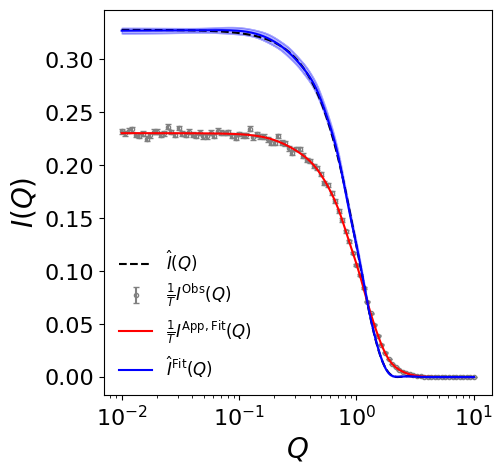

In [135]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

line1, = ax.plot(
    Q_grid, fQ_grid,
    '--', label=r'$\widehat{I}(Q)$',
    color='black', zorder=3
)

line2 = ax.errorbar(
    Q_obs, I_obs_sampled/(1-T),
    yerr=delta_I_obs/(1-T),
    fmt='.',
    label=r'$I^{\mathrm{obs}}(Q)$',
    color='gray',
    fillstyle='none',
    capsize=2,
    zorder=1   # <-- push errorbars to bottom
)

line3, = ax.plot(
    Q_obs, I_app_fit/(1-T),
    '-', color='r',
    label=r'$I^{\mathrm{App}}(Q)$',
    zorder=4
)

line4, = ax.plot(
    Q_fine, I_hat_fit,
    '-',
    label=r'$\widehat{I}^{\mathrm{fit}}(Q)$',
    fillstyle='none',
    color='blue',
    zorder=5
)

ax.fill_between(
    Q_fine,
    (I_hat_fit - delta_I_hat_fit),
    (I_hat_fit + delta_I_hat_fit),
    color='blue',
    alpha=0.3,
    step='mid',
    label=r'$\widehat{I}^{\mathrm{fit}}(Q) \pm \delta \widehat{I}(Q)$',
    zorder=2
)


handles = [line1, line2, line3, line4]
labels = [r'$\widehat{I}(Q)$', r'$\frac{1}{T}I^{\mathrm{Obs}}(Q)$', r'$\frac{1}{T}I^{\mathrm{App, Fit}}(Q)$', r'$\widehat{I}^{\mathrm{Fit}}(Q)$']
ax.legend(handles, labels, fontsize=12, frameon=False)

ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel(r'$Q$', fontsize=20)
ax.set_ylabel(r'$I(Q)$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(handles, labels, fontsize=12, frameon=False)
# ax.set_ylim(0, 2)

In [114]:
delta_I_hat_fit.shape

(20,)